In [1]:
# Draw PPS catchment outlines, original version, used single global identifier from PPS specs google sheet at
# https://docs.google.com/spreadsheets/d/1-6_LTxtRvdBnXfFOmfjUrX_TCRA4OF6G0YsLX2VS6Mc/edit#gid=0

# Draw PPS catchment outlines-AW2 used time-based identifiers at PPS configuration history google sheet at
# https://docs.google.com/spreadsheets/d/1Ww5qfxukYcCtuUA8vEWc86HiwxIAOIoKd2LKbOJGeE4/edit#gid=0

# This just uses NCES data directly, so doesn't include any PPS specifics

In [1]:
# Boilerplate from Randy cheatsheet at https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#
import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [2]:
# Wide display
from IPython.core.display import display, HTML
display(HTML("<style>#notebook-container { margin-left:-14px; width:calc(100% + 27px) !important; }</style>"))

In [3]:
import csv, json, math, os, numbers, pandas, re, scipy, scipy.sparse, shutil
import struct, subprocess, sys, threading, time, urllib2

def exec_ipynb(filename_or_url):
    nb = (urllib2.urlopen(filename_or_url) if re.match(r'https?:', filename_or_url) else open(filename_or_url)).read()
    jsonNb = json.loads(nb)
    #check for the modified formatting of Jupyter Notebook v4
    if(jsonNb['nbformat'] == 4):
        exec '\n'.join([''.join(cell['source']) for cell in jsonNb['cells'] if cell['cell_type'] == 'code']) in globals()
    else:
        exec '\n'.join([''.join(cell['input']) for cell in jsonNb['worksheets'][0]['cells'] if cell['cell_type'] == 'code']) in globals()

exec_ipynb('timelapse-utilities.ipynb')

In [4]:
def get_segments_from_ring(r):
    ret = set()
    for i in range(0, len(r)):
        ret.add((r[i - 1][0], r[i - 1][1], r[i][0], r[i][1]))
    return ret

def get_segments_from_polygon(p):
    return set.union(*[get_segments_from_ring(r) for r in p])

def get_segments_from_multipolygon(mp):
    return set.union(*[get_segments_from_polygon(p) for p in mp])

def get_segments(g):
    if 'features' in g:
        return set.union(*[get_segments(f) for f in g['features']])
    elif 'geometry' in g:
        if g['geometry']['type'] == 'Polygon':
            return get_segments_from_polygon(g['geometry']['coordinates'])
        elif g['geometry']['type'] == 'MultiPolygon':
            return get_segments_from_multipolygon(g['geometry']['coordinates'])
        else:
            raise Exception('unrecognized geometry type %s' % g['geometry']['type'])
    else:
        raise 'unrecognized type'
        
def LonLatToWebMercator(lon, lat):
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def WebMercatorToLonLat(x,y):
    lat = math.atan(math.exp((128.0 - y) * math.pi / 128.0)) * 360.0 / math.pi - 90.0
    lon = x * 360.0 / 256.0 - 180.0
    return [lon, lat]

def project_and_binarize_segment(segment, dest):
    (x1, y1) = LonLatToWebMercator(segment[0], segment[1])
    (x2, y2) = LonLatToWebMercator(segment[2], segment[3])
    dest.write(struct.pack('<ffff', x1, y1, x2, y2))

def binarize_geojson_outlines(src, dest):
    gj = json.load(open(src))
    print 'Read %d features from %s' % (len(gj['features']), src)
    segments = get_segments(gj)
    print '%d segments' % len(segments)

    try:
        os.makedirs(os.path.dirname(dest))
    except OSError:
        pass
        
    out = open(dest + '.tmp', 'w')
    for segment in segments:
        project_and_binarize_segment(segment, out)
    out.close()
    os.rename(dest + '.tmp', dest)
    print 'Created %s (%d segments)' % (dest, os.stat(dest).st_size / 16)

# Unified 2015/2016 boundary data

In [7]:
# Found newer files that have all levels together from https://nces.ed.gov/programs/edge/sabs
# Downloaded https://nces.ed.gov/programs/edge/data/SABS_1516.zip to
# hal15:~/uwsgi/dotmaptiles/data-visualization-tools/examples/lodes/allegheny_county/schools/alvin
p_1516 = gpd.read_file('allegheny_county/schools/alvin/SABS_1516/SABS_1516.shp').to_crs(epsg=4326)
p_1516['ncessch'] = p_1516['ncessch'].astype(numpy.str)

In [8]:
pa_1516_raw = p_1516[p_1516.leaid.str.contains('^42',regex=True)]
pa_1516=pa_1516_raw.copy()
pa_1516=pa_1516.set_index('ncessch')

In [42]:
pa_1516[(pa_1516.openEnroll!='0')]

,SrcName,schnam,leaid,gslo,gshi,defacto,stAbbrev,openEnroll,Shape_Leng,Shape_Area,level,MultiBdy,geometry
ncessch,,,,,,,,,,,,,
420228007562,None,Building 21 Allentown,4202280,09,09,0,PA,1,72537.205132,7.668612e+07,4,0,POLYGON ((-75.52983692778486 40.60442518077843...
420291001330,None,Wingate El Sch,4202910,KG,05,0,PA,2,246212.606945,1.553445e+09,1,0,POLYGON ((-78.13549876501565 40.81718811977917...
420291001331,None,Port Matilda El Sch,4202910,KG,05,0,PA,2,246212.606945,1.553445e+09,1,0,POLYGON ((-78.13549876501565 40.81718811977917...
420291001333,None,Howard El Sch,4202910,KG,05,0,PA,2,246212.606945,1.553445e+09,1,0,POLYGON ((-78.13549876501565 40.81718811977917...
420291001334,None,Mountaintop Area El Sch,4202910,KG,05,0,PA,2,246212.606945,1.553445e+09,1,0,POLYGON ((-78.13549876501565 40.81718811977917...
420291001335,None,Bald Eagle Area JSHS,4202910,06,12,0,PA,2,246212.606945,1.553445e+09,4,0,POLYGON ((-78.13549876501565 40.81718811977917...
420321004325,None,Rostraver El Sch,4203210,KG,06,0,PA,2,86743.709969,1.945115e+08,1,0,"POLYGON ((-79.90417326753949 40.1519749178636,..."
420321004328,None,Marion El Sch,4203210,KG,06,0,PA,2,86743.709969,1.945115e+08,1,0,"POLYGON ((-79.90417326753949 40.1519749178636,..."
420321004930,None,Belle Vernon Area HS,4203210,09,12,0,PA,2,86743.709969,1.945115e+08,3,0,"POLYGON ((-79.90417326753949 40.1519749178636,..."


In [29]:
nces_2015=pandas.read_hdf('allegheny_county/schools/nces/2015-ccd-computed.h5')
nces_2015_pa = nces_2015[nces_2015.LEAID.str.contains('^42',regex=True)].copy()

In [16]:
nces_2015_pa[nces_2015_pa.LEA_NAME.str.contains("Rox")]

,NCESSCH,MSTREET1,MSTREET2,MSTREET3,MCITY,MSTATE,MZIP,MZIP4,PHONE,LSTREET1,LSTREET2,LSTREET3,LCITY,LSTATE,LZIP,LZIP4,UNION,OUT_OF_STATE_FLAG,SCH_TYPE_TEXT,SCH_TYPE,RECON_STATUS,GSLO,GSHI,LEVEL,VIRTUAL,BIES,SY_STATUS_TEXT,SY_STATUS,UPDATED_STATUS_TEXT,UPDATED_STATUS,EFFECTIVE_DATE,CHARTER_TEXT,PKOFFERED,KGOFFERED,G1OFFERED,G2OFFERED,G3OFFERED,G4OFFERED,G5OFFERED,G6OFFERED,G7OFFERED,G8OFFERED,G9OFFERED,G10OFFERED,G11OFFERED,G12OFFERED,G13OFFERED,AEOFFERED,UGOFFERED,NOGRADES,CHARTAUTH1,CHARTAUTHN1,CHARTAUTH2,CHARTAUTHN2,IGOFFERED,WEBSITE,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,AE,TOTAL,MEMBER,AMPKM,AMPKF,ASPKM,ASPKF,HIPKM,HIPKF,BLPKM,BLPKF,WHPKM,WHPKF,HPPKM,HPPKF,TRPKM,TRPKF,AMKGM,AMKGF,ASKGM,ASKGF,HIKGM,HIKGF,BLKGM,BLKGF,WHKGM,WHKGF,HPKGM,HPKGF,TRKGM,TRKGF,AM01M,AM01F,AS01M,AS01F,HI01M,HI01F,BL01M,BL01F,WH01M,WH01F,HP01M,HP01F,TR01M,TR01F,AM02M,AM02F,AS02M,AS02F,HI02M,HI02F,BL02M,BL02F,WH02M,WH02F,HP02M,HP02F,TR02M,TR02F,AM03M,AM03F,AS03M,AS03F,HI03M,HI03F,BL03M,BL03F,WH03M,WH03F,HP03M,HP03F,TR03M,TR03F,AM04M,AM04F,AS04M,AS04F,HI04M,HI04F,BL04M,BL04F,WH04M,WH04F,HP04M,HP04F,TR04M,TR04F,AM05M,AM05F,AS05M,AS05F,HI05M,HI05F,BL05M,BL05F,WH05M,WH05F,HP05M,HP05F,TR05M,TR05F,AM06M,AM06F,AS06M,AS06F,HI06M,HI06F,BL06M,BL06F,WH06M,WH06F,HP06M,HP06F,TR06M,TR06F,AM07M,AM07F,AS07M,AS07F,HI07M,HI07F,BL07M,BL07F,WH07M,WH07F,HP07M,HP07F,TR07M,TR07F,AM08M,AM08F,AS08M,AS08F,HI08M,HI08F,BL08M,BL08F,WH08M,WH08F,HP08M,HP08F,TR08M,TR08F,AM09M,AM09F,AS09M,AS09F,HI09M,HI09F,BL09M,BL09F,WH09M,WH09F,HP09M,HP09F,TR09M,TR09F,AM10M,AM10F,AS10M,AS10F,HI10M,HI10F,BL10M,BL10F,WH10M,WH10F,HP10M,HP10F,TR10M,TR10F,AM11M,AM11F,AS11M,AS11F,HI11M,HI11F,BL11M,BL11F,WH11M,WH11F,HP11M,HP11F,TR11M,TR11F,AM12M,AM12F,AS12M,AS12F,HI12M,HI12F,BL12M,BL12F,WH12M,WH12F,HP12M,HP12F,TR12M,TR12F,AM13M,AM13F,AS13M,AS13F,HI13M,HI13F,BL13M,BL13F,WH13M,WH13F,HP13M,HP13F,TR13M,TR13F,AMUGM,AMUGF,ASUGM,ASUGF,HIUGM,HIUGF,BLUGM,BLUGF,WHUGM,WHUGF,HPUGM,HPUGF,TRUGM,TRUGF,AMAEM,AMAEF,ASAEM,ASAEF,HIAEM,HIAEF,BLAEM,BLAEF,WHAEM,WHAEF,HPAEM,HPAEF,TRAEM,TRAEF,AM,AMALM,AMALF,AS,ASALM,ASALF,HI,HIALM,HIALF,BL,BLALM,BLALF,WH,WHALM,WHALF,HP,HPALM,HPALF,TR,TRALM,TRALF,FTE,TITLEI_TEXT,TITLEI_STATUS,TITLEI,STITLEI,SHARED_TIME,MAGNET_TEXT,NSLPSTATUS_TEXT,NSLPSTATUS_CODE,TOTFRL,FRELCH,REDLCH,FIPST,LEAID,LEA_NAME,SCHID,SCH_NAME,SEANAME,STABR,STATENAME,ST_LEAID,ST_SCHID,SURVYEAR
77046,422283000477,1105 Valley St,NaN,NaN,McKees Rocks,PA,15136,NaN,4127713213,1105 Valley St,NaN,NaN,McKees Rocks,PA,15136,NaN,000,No,Regular School,1,No,09,12,3,No,No,Open,1,Open,1,04/04/16,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,Yes,No,No,No,No,NOT APPLICABLE,NOT APPLICABLE,NOT APPLICABLE,NOT APPLICABLE,R,NaN,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,78.0,74.0,87.0,80.0,-2.0,-2.0,-2.0,319.0,319.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,1.0,0.0,20.0,20.0,17.0,15.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,14.0,14.0,20.0,18.0,0.0,0.0,3.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,18.0,30.0,17.0,16.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,20.0,22.0,17.0,0.0,0.0,5.0,2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,2.0,1.0,1.0,4.0,3.0,1.0,150.0,66.0,84.0,142.0,76.0,66.0,0.0,0.

In [15]:
nces_2015_pa.LEA_NAME.value_counts()

Philadelphia City SD                           218
Pittsburgh SD                                   58
Central Bucks SD                                23
Allentown City SD                               22
Bethlehem Area SD                               22
Central Dauphin SD                              19
Reading SD                                      19
Lancaster SD                                    19
Erie City SD                                    18
North Penn SD                                   17
West Chester Area SD                            16
Butler Area SD                                  16
Chambersburg Area SD                            16
Scranton SD                                     16
Downingtown Area SD                             16
Council Rock SD                                 15
Upper Darby SD                                  14
West Shore SD                                   14
Pennsbury SD                                    14
Neshaminy SD                   

In [19]:
# Load Allegheny County zip codes
ac_zips_gj = gpd.read_file('allegheny_county/zip/allegheny_county_zips.geojson')
ac_zips_gj=ac_zips_gj.set_index('ZIP')

In [153]:
def zip_to_county(zipcode):
    try:
        return ac_zips_gj.loc[str(zipcode)].COUNTYNAME
    except:
        return None
        

In [154]:
zip_to_county(15213)

u'ALLEGHENY'

In [30]:
nces_2015_pa['COUNTY']=nces_2015_pa['MZIP'].map(zip_to_county)


In [69]:
    nces_2015_aiu=nces_2015_pa[(nces_2015_pa.COUNTY=='ALLEGHENY') & (nces_2015_pa.LEAID!='4219170') & (nces_2015_pa.SY_STATUS!='2') & (nces_2015_pa.SCH_TYPE=='1')].copy()

In [71]:
nces_2015_aiu

,NCESSCH,MSTREET1,MSTREET2,MSTREET3,MCITY,MSTATE,MZIP,MZIP4,PHONE,LSTREET1,LSTREET2,LSTREET3,LCITY,LSTATE,LZIP,LZIP4,UNION,OUT_OF_STATE_FLAG,SCH_TYPE_TEXT,SCH_TYPE,RECON_STATUS,GSLO,GSHI,LEVEL,VIRTUAL,BIES,SY_STATUS_TEXT,SY_STATUS,UPDATED_STATUS_TEXT,UPDATED_STATUS,EFFECTIVE_DATE,CHARTER_TEXT,PKOFFERED,KGOFFERED,G1OFFERED,G2OFFERED,G3OFFERED,G4OFFERED,G5OFFERED,G6OFFERED,G7OFFERED,G8OFFERED,G9OFFERED,G10OFFERED,G11OFFERED,G12OFFERED,G13OFFERED,AEOFFERED,UGOFFERED,NOGRADES,CHARTAUTH1,CHARTAUTHN1,CHARTAUTH2,CHARTAUTHN2,IGOFFERED,WEBSITE,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,AE,TOTAL,MEMBER,AMPKM,AMPKF,ASPKM,ASPKF,HIPKM,HIPKF,BLPKM,BLPKF,WHPKM,WHPKF,HPPKM,HPPKF,TRPKM,TRPKF,AMKGM,AMKGF,ASKGM,ASKGF,HIKGM,HIKGF,BLKGM,BLKGF,WHKGM,WHKGF,HPKGM,HPKGF,TRKGM,TRKGF,AM01M,AM01F,AS01M,AS01F,HI01M,HI01F,BL01M,BL01F,WH01M,WH01F,HP01M,HP01F,TR01M,TR01F,AM02M,AM02F,AS02M,AS02F,HI02M,HI02F,BL02M,BL02F,WH02M,WH02F,HP02M,HP02F,TR02M,TR02F,AM03M,AM03F,AS03M,AS03F,HI03M,HI03F,BL03M,BL03F,WH03M,WH03F,HP03M,HP03F,TR03M,TR03F,AM04M,AM04F,AS04M,AS04F,HI04M,HI04F,BL04M,BL04F,WH04M,WH04F,HP04M,HP04F,TR04M,TR04F,AM05M,AM05F,AS05M,AS05F,HI05M,HI05F,BL05M,BL05F,WH05M,WH05F,HP05M,HP05F,TR05M,TR05F,AM06M,AM06F,AS06M,AS06F,HI06M,HI06F,BL06M,BL06F,WH06M,WH06F,HP06M,HP06F,TR06M,TR06F,AM07M,AM07F,AS07M,AS07F,HI07M,HI07F,BL07M,BL07F,WH07M,WH07F,HP07M,HP07F,TR07M,TR07F,AM08M,AM08F,AS08M,AS08F,HI08M,HI08F,BL08M,BL08F,WH08M,WH08F,HP08M,HP08F,TR08M,TR08F,AM09M,AM09F,AS09M,AS09F,HI09M,HI09F,BL09M,BL09F,WH09M,WH09F,HP09M,HP09F,TR09M,TR09F,AM10M,AM10F,AS10M,AS10F,HI10M,HI10F,BL10M,BL10F,WH10M,WH10F,HP10M,HP10F,TR10M,TR10F,AM11M,AM11F,AS11M,AS11F,HI11M,HI11F,BL11M,BL11F,WH11M,WH11F,HP11M,HP11F,TR11M,TR11F,AM12M,AM12F,AS12M,AS12F,HI12M,HI12F,BL12M,BL12F,WH12M,WH12F,HP12M,HP12F,TR12M,TR12F,AM13M,AM13F,AS13M,AS13F,HI13M,HI13F,BL13M,BL13F,WH13M,WH13F,HP13M,HP13F,TR13M,TR13F,AMUGM,AMUGF,ASUGM,ASUGF,HIUGM,HIUGF,BLUGM,BLUGF,WHUGM,WHUGF,HPUGM,HPUGF,TRUGM,TRUGF,AMAEM,AMAEF,ASAEM,ASAEF,HIAEM,HIAEF,BLAEM,BLAEF,WHAEM,WHAEF,HPAEM,HPAEF,TRAEM,TRAEF,AM,AMALM,AMALF,AS,ASALM,ASALF,HI,HIALM,HIALF,BL,BLALM,BLALF,WH,WHALM,WHALF,HP,HPALM,HPALF,TR,TRALM,TRALF,FTE,TITLEI_TEXT,TITLEI_STATUS,TITLEI,STITLEI,SHARED_TIME,MAGNET_TEXT,NSLPSTATUS_TEXT,NSLPSTATUS_CODE,TOTFRL,FRELCH,REDLCH,FIPST,LEAID,LEA_NAME,SCHID,SCH_NAME,SEANAME,STABR,STATENAME,ST_LEAID,ST_SCHID,SURVYEAR,COUNTY
74433,420001700336,1214 Liverpool Street,NaN,NaN,Pittsburgh,PA,15233,NaN,4123220585,1214 Liverpool Street,NaN,NaN,Pittsburgh,PA,15233,NaN,000,No,Regular School,1,No,KG,08,1,No,No,Open,1,Open,1,04/04/16,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,Pittsburgh SD,102027451,NOT APPLICABLE,NOT APPLICABLE,R,NaN,-2.0,41.0,45.0,44.0,44.0,43.0,41.0,24.0,22.0,21.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,325.0,325.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,19.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,22.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,22.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,26.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,23.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,312.0,160.0,152.0,6.0,5.0,1.0,0.0,0.0,0.0,6.0,3.0,3.0,25.60,Title I schoolwide school,5,Yes

In [72]:
# Merge with school boundaries
aiu_2015=pd.merge(pa_1516.reset_index(),nces_2015_aiu, left_on='ncessch', right_on='NCESSCH')

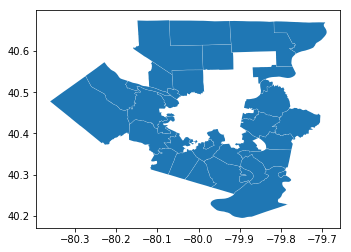

In [76]:
# Just look at high schools
aiu_hs_2015 = aiu_2015[(aiu_2015.gshi>='09')&(aiu_2015.gshi!='KG') & (aiu_2015.gshi!='PK')]
# Inset by ~25 m
aiu_hs_2015_eroded = aiu_hs_2015.geometry.buffer(-0.0003)
aiu_hs_2015_eroded.plot()

In [80]:
try:
    os.unlink('allegheny_county/schools/alvin/schools_aiu_1516-hs.geojson')
except:
    pass
aiu_hs_2015_eroded.to_file('allegheny_county/schools/alvin/schools_aiu_1516-hs.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/schools_aiu_1516-hs.geojson', 
                          'allegheny_county/schools_aiu_1516-hs.bin')

Read 34 features from allegheny_county/schools/alvin/schools_aiu_1516-hs.geojson
47470 segments
Created allegheny_county/schools_aiu_1516-hs.bin (47470 segments)


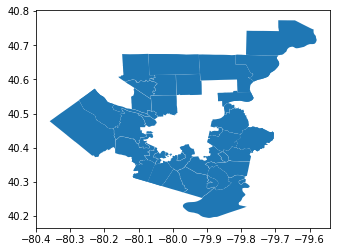

In [77]:
# Just look at middle schools
aiu_ms_2015 = aiu_2015[((aiu_2015.gshi>='06')&(aiu_2015.gshi!='KG') & (aiu_2015.gshi!='PK'))&(aiu_2015.gslo<='08')]
# Inset by ~25 m
aiu_ms_2015_eroded = aiu_ms_2015.geometry.buffer(-0.0003)
aiu_ms_2015_eroded.plot()

In [81]:
try:
    os.unlink('allegheny_county/schools/alvin/schools_aiu_1516-ms.geojson')
except:
    pass
aiu_ms_2015_eroded.to_file('allegheny_county/schools/alvin/schools_aiu_1516-ms.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/schools_aiu_1516-ms.geojson', 
                          'allegheny_county/schools_aiu_1516-ms.bin')

Read 48 features from allegheny_county/schools/alvin/schools_aiu_1516-ms.geojson
51566 segments
Created allegheny_county/schools_aiu_1516-ms.bin (51566 segments)


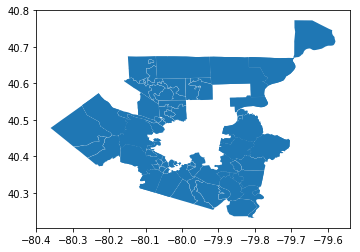

In [78]:
# Just look at elementary schools
aiu_el_2015 = aiu_2015[((aiu_2015.gslo<='05')|(aiu_2015.gslo=='KG') | (aiu_2015.gslo=='PK'))]
# Inset by ~25 m
aiu_el_2015_eroded = aiu_el_2015.geometry.buffer(-0.0003)
aiu_el_2015_eroded.plot()

In [82]:
try:
    os.unlink('allegheny_county/schools/alvin/schools_aiu_1516-el.geojson')
except:
    pass
aiu_el_2015_eroded.to_file('allegheny_county/schools/alvin/schools_aiu_1516-el.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/schools_aiu_1516-el.geojson', 
                          'allegheny_county/schools_aiu_1516-el.bin')

Read 104 features from allegheny_county/schools/alvin/schools_aiu_1516-el.geojson
67323 segments
Created allegheny_county/schools_aiu_1516-el.bin (67323 segments)


# Setup NCES per-year file and column mapping

In [591]:
nces_2015_col_remap={'School Name':'SCH_NAME','Zip':'MZIP','Latitude':'LAT1516','Longitude':'LON1516','Total enrollment':'TOTAL',
                     'Black enrollment':'BL','White enrollment':'WH',
                     'Asian enrollment':'AS','Hispanic enrollment':'HI',
                     'LEAID':'LEAID', 'STATUS':'SY_STATUS', 'TYPE':'SCH_TYPE', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO', 'GSHI':'GSHI'}

nces_2014_col_remap={'School Name':'SCH_NAME','Zip':'MZIP','Latitude':'LATCODE','Longitude':'LONGCODE','Total enrollment':'TOTAL',
                     'Black enrollment':'BL','White enrollment':'WH',
                     'Asian enrollment':'AS','Hispanic enrollment':'HI',
                     'LEAID':'LEAID', 'STATUS':'SY_STATUS', 'TYPE':'SCH_TYPE', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO', 'GSHI':'GSHI'
                    }

nces_2013_col_remap={'School Name':'SCHNAM','Zip':'MZIP','Latitude':'LATCOD','Longitude':'LONCOD','Total enrollment':'TOTETH',
                     'Black enrollment':'BLACK','White enrollment':'WHITE',
                     'Asian enrollment':'ASIAN','Hispanic enrollment':'HISP',
                     'LEAID':'LEAID', 'STATUS':'STATUS', 'TYPE':'TYPE', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO', 'GSHI':'GSHI'
                    }

nces_2009_col_remap={'School Name':'SCHNAM09','Zip':'MZIP09','Latitude':'LATCOD09','Longitude':'LONCOD09','Total enrollment':'TOTETH09',
                     'Black enrollment':'BLACK09','White enrollment':'WHITE09',
                     'Asian enrollment':'ASIAN09','Hispanic enrollment':'HISP09',
                     'LEAID':'LEAID', 'STATUS':'STATUS09', 'TYPE':'TYPE09', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO09', 'GSHI':'GSHI09'
                    }

nces_2008_col_remap={'School Name':'SCHNAM08','Zip':'MZIP08','Latitude':'LATCOD08','Longitude':'LONCOD08','Total enrollment':'TOTETH08',
                     'Black enrollment':'BLACK08','White enrollment':'WHITE08',
                     'Asian enrollment':'ASIAN08','Hispanic enrollment':'HISP08',
                     'LEAID':'LEAID', 'STATUS':'STATUS08', 'TYPE':'TYPE08', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO08', 'GSHI':'GSHI08'
                    }

nces_2007_col_remap={'School Name':'SCHNAM07','Zip':'MZIP07','Latitude':'LATCOD07','Longitude':'LONCOD07','Total enrollment':'TOTETH07',
                     'Black enrollment':'BLACK07','White enrollment':'WHITE07',
                     'Asian enrollment':'ASIAN07','Hispanic enrollment':'HISP07',
                     'LEAID':'LEAID', 'STATUS':'STATUS07', 'TYPE':'TYPE07', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO07', 'GSHI':'GSHI07'
                    }

nces_2006_col_remap={'School Name':'SCHNAM06','Zip':'MZIP06','Latitude':'LATCOD06','Longitude':'LONCOD06','Total enrollment':'TOTETH06',
                     'Black enrollment':'BLACK06','White enrollment':'WHITE06',
                     'Asian enrollment':'ASIAN06','Hispanic enrollment':'HISP06',
                     'LEAID':'LEAID', 'STATUS':'STATUS06', 'TYPE':'TYPE06', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO06', 'GSHI':'GSHI06'
                    }

nces_2005_col_remap={'School Name':'SCHNAM05','Zip':'MZIP05','Latitude':'LATCOD05','Longitude':'LONCOD05','Total enrollment':'TOTETH05',
                     'Black enrollment':'BLACK05','White enrollment':'WHITE05',
                     'Asian enrollment':'ASIAN05','Hispanic enrollment':'HISP05',
                     'LEAID':'LEAID', 'STATUS':'STATUS05', 'TYPE':'TYPE05', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO05', 'GSHI':'GSHI05'
                    }

nces_2004_col_remap={'School Name':'SCHNAM04','Zip':'MZIP04','Latitude':'LATCOD04','Longitude':'LONCOD04','Total enrollment':'TOTETH04',
                     'Black enrollment':'BLACK04','White enrollment':'WHITE04',
                     'Asian enrollment':'ASIAN04','Hispanic enrollment':'HISP04',
                     'LEAID':'LEAID', 'STATUS':'STATUS04', 'TYPE':'TYPE04', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO04', 'GSHI':'GSHI04'
                    }

nces_2003_col_remap={'School Name':'SCHNAM03','Zip':'MZIP03','Latitude':'LATCOD03','Longitude':'LONCOD03','Total enrollment':'TOTETH03',
                     'Black enrollment':'BLACK03','White enrollment':'WHITE03',
                     'Asian enrollment':'ASIAN03','Hispanic enrollment':'HISP03',
                     'LEAID':'LEAID', 'STATUS':'STATUS03', 'TYPE':'TYPE03', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO03', 'GSHI':'GSHI03'
                    }

nces_2002_col_remap={'School Name':'SCHNAM02','Zip':'MZIP02','Latitude':'LATCOD02','Longitude':'LONCOD02','Total enrollment':'TOTETH02',
                     'Black enrollment':'BLACK02','White enrollment':'WHITE02',
                     'Asian enrollment':'ASIAN02','Hispanic enrollment':'HISP02',
                     'LEAID':'LEAID', 'STATUS':'STATUS02', 'TYPE':'TYPE02', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO02', 'GSHI':'GSHI02'
                    }

nces_2001_col_remap={'School Name':'SCHNAM01','Zip':'MZIP01','Latitude':'LATCOD01','Longitude':'LONCOD01','Total enrollment':'TOTETH01',
                     'Black enrollment':'BLACK01','White enrollment':'WHITE01',
                     'Asian enrollment':'ASIAN01','Hispanic enrollment':'HISP01',
                     'LEAID':'LEAID', 'STATUS':'STATUS01', 'TYPE':'TYPE01', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO01', 'GSHI':'GSHI01'
                    }

nces_2000_col_remap={'School Name':'SCHNAM00','Zip':'MZIP00','Latitude':'LATCOD00','Longitude':'LONCOD00','Total enrollment':'TOTETH00',
                     'Black enrollment':'BLACK00','White enrollment':'WHITE00',
                     'Asian enrollment':'ASIAN00','Hispanic enrollment':'HISP00',
                     'LEAID':'LEAID', 'STATUS':'STATUS00', 'TYPE':'TYPE00', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO00', 'GSHI':'GSHI00'
                    }

nces_1999_col_remap={'School Name':'SCHNAM99','Zip':'MZIP99','Latitude':'LATCOD99','Longitude':'LONCOD99','Total enrollment':'TOTETH99',
                     'Black enrollment':'BLACK99','White enrollment':'WHITE99',
                     'Asian enrollment':'ASIAN99','Hispanic enrollment':'HISP99',
                     'LEAID':'LEAID', 'STATUS':'STATUS99', 'TYPE':'TYPE99', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO99', 'GSHI':'GSHI99'
                    }

nces_1998_col_remap={'School Name':'SCHNAM98','Zip':'MZIP98','Latitude':'LATCOD98','Longitude':'LONCOD98','Total enrollment':'TOTETH98',
                     'Black enrollment':'BLACK98','White enrollment':'WHITE98',
                     'Asian enrollment':'ASIAN98','Hispanic enrollment':'HISP98',
                     'LEAID':'LEAID', 'STATUS':'STATUS98', 'TYPE':'TYPE98', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO98', 'GSHI':'GSHI98'
                    }

nces_1997_col_remap={'School Name':'SCHNAM97','Zip':'ZIP97','Latitude':'LATCOD97','Longitude':'LONCOD97','Total enrollment':'TOTETH97',
                     'Black enrollment':'BLACK97','White enrollment':'WHITE97',
                     'Asian enrollment':'ASIAN97','Hispanic enrollment':'HISP97',
                     'LEAID':'LEAID', 'STATUS':'STATUS97', 'TYPE':'TYPE97', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO97', 'GSHI':'GSHI97'
                    }

nces_1996_col_remap={'School Name':'SCHNAM96','Zip':'ZIP96','Latitude':'LATCOD96','Longitude':'LONCOD96','Total enrollment':'TOTETH96',
                     'Black enrollment':'BLACK96','White enrollment':'WHITE96',
                     'Asian enrollment':'ASIAN96','Hispanic enrollment':'HISP96',
                     'LEAID':'LEAID', 'STATUS':'STATUS96', 'TYPE':'TYPE96', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO96', 'GSHI':'GSHI96'
                    }

nces_1995_col_remap={'School Name':'SCHNAM95','Zip':'ZIP95','Latitude':'LATCOD95','Longitude':'LONCOD95','Total enrollment':'TOTETH95',
                     'Black enrollment':'BLACK95','White enrollment':'WHITE95',
                     'Asian enrollment':'ASIAN95','Hispanic enrollment':'HISP95',
                     'LEAID':'LEAID', 'STATUS':'STATUS95', 'TYPE':'TYPE95', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO95', 'GSHI':'GSHI95'
                    }

nces_1994_col_remap={'School Name':'SCHNAM94','Zip':'ZIP94','Latitude':'LATCOD94','Longitude':'LONCOD94','Total enrollment':'TOTETH94',
                     'Black enrollment':'BLACK94','White enrollment':'WHITE94',
                     'Asian enrollment':'ASIAN94','Hispanic enrollment':'HISP94',
                     'LEAID':'LEAID', 'STATUS':'STATUS94', 'TYPE':'TYPE94', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSL094', 'GSHI':'GSHI94'
                    }

nces_1993_col_remap={'School Name':'SCHNAM93','Zip':'ZIP93','Latitude':'LATCOD93','Longitude':'LONCOD93','Total enrollment':'TOTETH93',
                     'Black enrollment':'BLACK93','White enrollment':'WHITE93',
                     'Asian enrollment':'ASIAN93','Hispanic enrollment':'HISP93',
                     'LEAID':'LEAID', 'STATUS':'STATUS93', 'TYPE':'TYPE93', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO93', 'GSHI':'GSHI93'
                    }

nces_1992_col_remap={'School Name':'SCHNAM92','Zip':'ZIP92','Latitude':'LATCOD92','Longitude':'LONCOD92','Total enrollment':'TOTETH92',
                     'Black enrollment':'BLACK92','White enrollment':'WHITE92',
                     'Asian enrollment':'ASIAN92','Hispanic enrollment':'HISP92',
                     'LEAID':'LEAID', 'STATUS':'STATUS92', 'TYPE':'TYPE92', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO92', 'GSHI':'GSHI92'
                    }

nces_1991_col_remap={'School Name':'SCHNAM91','Zip':'ZIP91','Latitude':'LATCOD91','Longitude':'LONCOD91','Total enrollment':'MEMBER91',
                     'Black enrollment':'BLACK91','White enrollment':'WHITE91',
                     'Asian enrollment':'ASIAN91','Hispanic enrollment':'HISP91',
                     'LEAID':'LEAID', 'STATUS':'STATUS91', 'TYPE':'TYPE91', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO91', 'GSHI':'GSHI91'
                    }

nces_1990_col_remap={'School Name':'SCHNAM90','Zip':'ZIP90','Latitude':'LATCOD90','Longitude':'LONCOD90','Total enrollment':'MEMBER90',
                     'Black enrollment':'BLACK90','White enrollment':'WHITE90',
                     'Asian enrollment':'ASIAN90','Hispanic enrollment':'HISP90',
                     'LEAID':'LEAID', 'STATUS':'STATUS90', 'TYPE':'TYPE90', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO90', 'GSHI':'GSHI90'
                    }

nces_info = {
    '2015':{'col_remap':nces_2015_col_remap, 'path':'allegheny_county/schools/nces/2015-ccd-computed-v2.h5'},
    '2014':{'col_remap':nces_2014_col_remap, 'path':'allegheny_county/schools/nces/2014-ccd-computed-v2.h5'},
    '2013':{'col_remap':nces_2013_col_remap, 'path':'allegheny_county/schools/nces/2013-ccd-computed.h5'},
    '2012':{'col_remap':nces_2013_col_remap, 'path':'allegheny_county/schools/nces/2012-ccd-computed.h5'},
    '2011':{'col_remap':nces_2013_col_remap, 'path':'allegheny_county/schools/nces/2011-ccd-computed.h5'},
    '2010':{'col_remap':nces_2013_col_remap, 'path':'allegheny_county/schools/nces/2010-ccd-computed.h5'},           
    '2009':{'col_remap':nces_2009_col_remap, 'path':'allegheny_county/schools/nces/2009-ccd-computed.h5'},           
    '2008':{'col_remap':nces_2008_col_remap, 'path':'allegheny_county/schools/nces/2008-ccd-computed.h5'},           
    '2007':{'col_remap':nces_2007_col_remap, 'path':'allegheny_county/schools/nces/2007-ccd-computed.h5'},    
    '2006':{'col_remap':nces_2006_col_remap, 'path':'allegheny_county/schools/nces/2006-ccd-computed-v2.h5'},           
    '2005':{'col_remap':nces_2005_col_remap, 'path':'allegheny_county/schools/nces/2005-ccd-computed-v2.h5'},           
    '2004':{'col_remap':nces_2004_col_remap, 'path':'allegheny_county/schools/nces/2004-ccd-computed-v2.h5'},           
    '2003':{'col_remap':nces_2003_col_remap, 'path':'allegheny_county/schools/nces/2003-ccd-computed-v2.h5'},           
    '2002':{'col_remap':nces_2002_col_remap, 'path':'allegheny_county/schools/nces/2002-ccd-computed-v2.h5'},           
    '2001':{'col_remap':nces_2001_col_remap, 'path':'allegheny_county/schools/nces/2001-ccd-computed-v2.h5'},           
    '2000':{'col_remap':nces_2000_col_remap, 'path':'allegheny_county/schools/nces/2000-ccd-computed-v2.h5'},           
    '1999':{'col_remap':nces_1999_col_remap, 'path':'allegheny_county/schools/nces/1999-ccd-computed-v2.h5'},           
    '1998':{'col_remap':nces_1998_col_remap, 'path':'allegheny_county/schools/nces/1998-ccd-computed-v2.h5'},           
    '1997':{'col_remap':nces_1997_col_remap, 'path':'allegheny_county/schools/nces/1997-ccd-computed-v2.h5'},           
    '1996':{'col_remap':nces_1996_col_remap, 'path':'allegheny_county/schools/nces/1996-ccd-computed-v2.h5'},           
    '1995':{'col_remap':nces_1995_col_remap, 'path':'allegheny_county/schools/nces/1995-ccd-computed-v2.h5'},           
    '1994':{'col_remap':nces_1994_col_remap, 'path':'allegheny_county/schools/nces/1994-ccd-computed-v2.h5'},           
    '1993':{'col_remap':nces_1993_col_remap, 'path':'allegheny_county/schools/nces/1993-ccd-computed-v2.h5'},           
    '1992':{'col_remap':nces_1992_col_remap, 'path':'allegheny_county/schools/nces/1992-ccd-computed-v2.h5'},           
    '1991':{'col_remap':nces_1991_col_remap, 'path':'allegheny_county/schools/nces/1991-ccd-computed-v2.h5'},           
    '1990':{'col_remap':nces_1990_col_remap, 'path':'allegheny_county/schools/nces/1990-ccd-computed-v2.h5'},           
}

In [447]:
def nces_get_hs_vec(df, year):
    col_remap=nces_info[year]['col_remap']
    return ((df[col_remap['GSHI']]>='09')&(df[col_remap['GSHI']]!='KG')&(df[col_remap['GSHI']]!='PK'))

def nces_get_ms_vec(df, year):
    col_remap=nces_info[year]['col_remap']
    return ((df[col_remap['GSHI']]>='06')&(df[col_remap['GSHI']]!='KG') & (df[col_remap['GSHI']]!='PK'))&((df[col_remap['GSLO']]<='08')|(df[col_remap['GSLO']]=='KG') | (df[col_remap['GSLO']]=='PK'))

def nces_get_el_vec(df, year):
    col_remap=nces_info[year]['col_remap']
    return ((df[col_remap['GSLO']]<='05')|(df[col_remap['GSLO']]=='KG') | (df[col_remap['GSLO']]=='PK'))

# Pass in 'hs', 'ms', or 'el' for level to call the above functions
def nces_get_level_vec(df, year, level):
    if(level=='hs'):
        return nces_get_hs_vec(df, year)
    elif(level=='ms'):
        return nces_get_ms_vec(df, year)
    elif(level=='el'):
        return nces_get_el_vec(df, year)

# Set up filters

In [461]:
def nces_filter_leaid(df, year, leaid):
    col_remap=nces_info[year]['col_remap']
    ret=df[(df[col_remap['LEAID']].fillna('').astype(str)==leaid)].copy()
    return ret

def nces_filter_pps(df, year):
    return nces_filter_leaid(df, year, '4219170')

def nces_filter_aiu(df, year):
    col_remap=nces_info[year]['col_remap']
    # Replace any non-numeric values in Zip with 0's, as otherwise it'll choke on letters
    df['COUNTY']=pd.to_numeric(df[col_remap['Zip']], errors='coerce').fillna(0).astype(int).map(zip_to_county)
    # Clean up status and type as well
    #print "Type of STATUS is %s" % (df[col_remap['STATUS']].dtype.name)
    #print "Type of TYPE is %s" % (df[col_remap['TYPE']].dtype.name)
    #print "Type of Total enrollment is %s" % (df[col_remap['Total enrollment']].dtype.name)
    if(df[col_remap['STATUS']].dtype.name=='object'):
        df[col_remap['STATUS']] = df[col_remap['STATUS']].fillna(2).str.replace('[^\d]','0',regex=True).astype(int)
    if(df[col_remap['TYPE']].dtype.name=='object'):
        df[col_remap['TYPE']] = df[col_remap['TYPE']].fillna(2).str.replace('[^\d]','0',regex=True).astype(int)
   
    ret=df[(df.COUNTY=='ALLEGHENY') & (df[col_remap['LEAID']].fillna('').astype(str)!='4219170') & 
           (df[col_remap['STATUS']]!=2)& (df[col_remap['TYPE']]==1) & 
           (pd.to_numeric(df[col_remap['Total enrollment']], errors='coerce')>0)].copy()
    return ret

def nces_filter_minneapolis(df, year):
    return nces_filter_leaid(df, year, '2721240')

def nces_filter_lincoln_ne(df, year):
    return nces_filter_leaid(df, year, '3172840')

def nces_filter_georgetown_tx(df, year):
    return nces_filter_leaid(df, year, '4820600')

def nces_filter_waxahachie_tx(df, year):
    return nces_filter_leaid(df, year, '4844730')

In [472]:
# Map area names, which will be used in generating file names, to filters to use for selecting schools to process
nces_filter_map = {'aiu': nces_filter_aiu, 
                  'pps': nces_filter_pps,
                  'minneapolis': nces_filter_minneapolis,
                  'lincoln_ne': nces_filter_lincoln_ne,
                  'georgetown_tx': nces_filter_georgetown_tx,
                  'waxahachie_tx': nces_filter_waxahachie_tx,
                 }

# Boundaries

In [428]:
# This only needs to be executed once
# Read in all 2015-16 boundaries
p_1516 = gpd.read_file('allegheny_county/schools/alvin/SABS_1516/SABS_1516.shp').to_crs(epsg=4326)

# Merge with school boundaries for that year
nces_2015=pandas.read_hdf('allegheny_county/schools/nces/2015-ccd-computed.h5')
nces_2015_m=pd.merge(p_1516.reset_index(),nces_2015, left_on='ncessch', right_on='NCESSCH')

In [439]:
# This takes a filter function and a string describing the area and generates boundary files
def generate_nces_boundaries(filter_func, area_str):
    # Use the supplied filter to get the desired subset of schools
    df = filter_func(nces_2015_m,'2015')
    for level in ['hs','ms','el']:
        # Generate outfile name 
        gj_outfile_name = 'allegheny_county/schools/alvin/schools_{}_1516-{}.geojson'.format(area_str, level)
        bin_outfile_name = 'allegheny_county/schools_{}_1516-{}.bin'.format(area_str, level)
        # Apply filter function to use just the desired subset of schools
        df_level = df[nces_get_level_vec(df, '2015', level)]
        
        print "Generating boundaries for %s %s (%d schools) ->\n  %s\n  %s" % (area_str, level, len(df_level), gj_outfile_name, bin_outfile_name)
        
        # Inset by ~25 m
        df_level_eroded = df_level.geometry.buffer(-0.0003)

        # Save to the output file, deleting it first if it already exists
        try:
            os.unlink(gj_outfile_name)
        except:
            pass
        df_level_eroded.to_file(gj_outfile_name, driver="GeoJSON")
        binarize_geojson_outlines(gj_outfile_name, bin_outfile_name)

In [452]:
# Pittsburgh public schools
generate_nces_boundaries(nces_filter_pps,'pps')

Generating boundaries for pps hs (10 schools) ->
  allegheny_county/schools/alvin/schools_pps_1516-hs.geojson
  allegheny_county/schools_pps_1516-hs.bin
Read 10 features from allegheny_county/schools/alvin/schools_pps_1516-hs.geojson
20279 segments
Created allegheny_county/schools_pps_1516-hs.bin (20279 segments)
Generating boundaries for pps ms (24 schools) ->
  allegheny_county/schools/alvin/schools_pps_1516-ms.geojson
  allegheny_county/schools_pps_1516-ms.bin
Read 24 features from allegheny_county/schools/alvin/schools_pps_1516-ms.geojson
26546 segments
Created allegheny_county/schools_pps_1516-ms.bin (26546 segments)
Generating boundaries for pps el (35 schools) ->
  allegheny_county/schools/alvin/schools_pps_1516-el.geojson
  allegheny_county/schools_pps_1516-el.bin
Read 35 features from allegheny_county/schools/alvin/schools_pps_1516-el.geojson
34207 segments
Created allegheny_county/schools_pps_1516-el.bin (34207 segments)


In [455]:
# Minneapolis public schools
generate_nces_boundaries(nces_filter_minneapolis,'minneapolis')

Generating boundaries for minneapolis hs (9 schools) ->
  allegheny_county/schools/alvin/schools_minneapolis_1516-hs.geojson
  allegheny_county/schools_minneapolis_1516-hs.bin
Read 9 features from allegheny_county/schools/alvin/schools_minneapolis_1516-hs.geojson
3042 segments
Created allegheny_county/schools_minneapolis_1516-hs.bin (3042 segments)
Generating boundaries for minneapolis ms (16 schools) ->
  allegheny_county/schools/alvin/schools_minneapolis_1516-ms.geojson
  allegheny_county/schools_minneapolis_1516-ms.bin
Read 16 features from allegheny_county/schools/alvin/schools_minneapolis_1516-ms.geojson
3294 segments
Created allegheny_county/schools_minneapolis_1516-ms.bin (3294 segments)
Generating boundaries for minneapolis el (30 schools) ->
  allegheny_county/schools/alvin/schools_minneapolis_1516-el.geojson
  allegheny_county/schools_minneapolis_1516-el.bin
Read 30 features from allegheny_county/schools/alvin/schools_minneapolis_1516-el.geojson
3977 segments
Created alleghen

In [457]:
# Lincoln, NE public schools
generate_nces_boundaries(nces_filter_lincoln_ne,'lincoln_ne')

Generating boundaries for lincoln_ne hs (6 schools) ->
  allegheny_county/schools/alvin/schools_lincoln_ne_1516-hs.geojson
  allegheny_county/schools_lincoln_ne_1516-hs.bin
Read 6 features from allegheny_county/schools/alvin/schools_lincoln_ne_1516-hs.geojson
15141 segments
Created allegheny_county/schools_lincoln_ne_1516-hs.bin (15141 segments)
Generating boundaries for lincoln_ne ms (11 schools) ->
  allegheny_county/schools/alvin/schools_lincoln_ne_1516-ms.geojson
  allegheny_county/schools_lincoln_ne_1516-ms.bin
Read 11 features from allegheny_county/schools/alvin/schools_lincoln_ne_1516-ms.geojson
16641 segments
Created allegheny_county/schools_lincoln_ne_1516-ms.bin (16641 segments)
Generating boundaries for lincoln_ne el (38 schools) ->
  allegheny_county/schools/alvin/schools_lincoln_ne_1516-el.geojson
  allegheny_county/schools_lincoln_ne_1516-el.bin
Read 38 features from allegheny_county/schools/alvin/schools_lincoln_ne_1516-el.geojson
22650 segments
Created allegheny_county/

In [460]:
# Georgetown, TX public schools
generate_nces_boundaries(nces_filter_georgetown_tx,'georgetown_tx')

Generating boundaries for georgetown_tx hs (2 schools) ->
  allegheny_county/schools/alvin/schools_georgetown_tx_1516-hs.geojson
  allegheny_county/schools_georgetown_tx_1516-hs.bin
Read 2 features from allegheny_county/schools/alvin/schools_georgetown_tx_1516-hs.geojson
7101 segments
Created allegheny_county/schools_georgetown_tx_1516-hs.bin (7101 segments)
Generating boundaries for georgetown_tx ms (3 schools) ->
  allegheny_county/schools/alvin/schools_georgetown_tx_1516-ms.geojson
  allegheny_county/schools_georgetown_tx_1516-ms.bin
Read 3 features from allegheny_county/schools/alvin/schools_georgetown_tx_1516-ms.geojson
8099 segments
Created allegheny_county/schools_georgetown_tx_1516-ms.bin (8099 segments)
Generating boundaries for georgetown_tx el (10 schools) ->
  allegheny_county/schools/alvin/schools_georgetown_tx_1516-el.geojson
  allegheny_county/schools_georgetown_tx_1516-el.bin
Read 10 features from allegheny_county/schools/alvin/schools_georgetown_tx_1516-el.geojson
8468

In [462]:
# Waxahachie, TX public schools
generate_nces_boundaries(nces_filter_waxahachie_tx,'waxahachie_tx')

Generating boundaries for waxahachie_tx hs (4 schools) ->
  allegheny_county/schools/alvin/schools_waxahachie_tx_1516-hs.geojson
  allegheny_county/schools_waxahachie_tx_1516-hs.bin
Read 4 features from allegheny_county/schools/alvin/schools_waxahachie_tx_1516-hs.geojson
6246 segments
Created allegheny_county/schools_waxahachie_tx_1516-hs.bin (6246 segments)
Generating boundaries for waxahachie_tx ms (2 schools) ->
  allegheny_county/schools/alvin/schools_waxahachie_tx_1516-ms.geojson
  allegheny_county/schools_waxahachie_tx_1516-ms.bin
Read 2 features from allegheny_county/schools/alvin/schools_waxahachie_tx_1516-ms.geojson
6222 segments
Created allegheny_county/schools_waxahachie_tx_1516-ms.bin (6222 segments)
Generating boundaries for waxahachie_tx el (7 schools) ->
  allegheny_county/schools/alvin/schools_waxahachie_tx_1516-el.geojson
  allegheny_county/schools_waxahachie_tx_1516-el.bin
Read 7 features from allegheny_county/schools/alvin/schools_waxahachie_tx_1516-el.geojson
7665 s

In [ ]:
df = nces_filter_lincoln_ne(nces_2015_m,'2015')
df[nces_get_level_vec(df, '2015', 'hs')]

# Enrollment

In [ ]:
# The primary key of enrollment map is the area string, such as 'aiu' or 'pps'.  The value for each area string is a map of 
# years to data frames with enrollment data for that year.
enrollment_map={}

In [571]:
enrollment_colnames=['School Name','GSLO','GSHI','Latitude','Longitude','Total enrollment','Black enrollment','White enrollment','Asian enrollment','Hispanic enrollment','Other enrollment']

In [95]:
def read_nces_hdf(year):
    return pandas.read_hdf(nces_info[year]['path'])

In [574]:
def generate_nces_enrollment_df(df, year):
    # Rename to match enrollment_map format
    col_remap=nces_info[year]['col_remap']
    colnames = enrollment_colnames[:]
    
    df=df.set_index(col_remap['NCESSCH'])
    df['School Name']=df[col_remap['School Name']]
    df['GSLO']=df[col_remap['GSLO']]
    df['GSHI']=df[col_remap['GSHI']]
    if col_remap['Latitude'] in list(df) and col_remap['Longitude'] in list(df):        
        df['Latitude']=pd.to_numeric(df[col_remap['Latitude']], errors='coerce')
        df['Longitude']=pd.to_numeric(df[col_remap['Longitude']], errors='coerce')
         
        # Starting in 2005 the latitude and longitude are fixed point strings.  Detect this by seeing if latitude off by orders of magnitude
        # Note that this was written for Allegheny Couty, PA, and won't work as well at significantly different latitudes
        div_factor = (10**round(np.log10(df['Latitude'].mean()/40)))
        if(div_factor>=2):
            print "Dividing lat/lon by %f" % (div_factor)
            df['Latitude']=df['Latitude']/div_factor
            df['Longitude']=df['Longitude']/div_factor
    else:
        print "Missing Latitude/Longitude (no columns for %s and %s)" % (col_remap['Latitude'],col_remap['Longitude'])
        colnames.remove('Latitude')
        colnames.remove('Longitude')
   
    df['Black enrollment']=pd.to_numeric(df[col_remap['Black enrollment']], errors='coerce').fillna(0).astype(int)
    df['White enrollment']=pd.to_numeric(df[col_remap['White enrollment']], errors='coerce').fillna(0).astype(int)
    df['Asian enrollment']=pd.to_numeric(df[col_remap['Asian enrollment']], errors='coerce').fillna(0).astype(int)
    df['Hispanic enrollment']=pd.to_numeric(df[col_remap['Hispanic enrollment']], errors='coerce').fillna(0).astype(int)
    df['Total enrollment']=pd.to_numeric(df[col_remap['Total enrollment']], errors='coerce').fillna(0).astype(int)
    df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
    return df[df['Total enrollment']>0][colnames]

In [467]:
def process_aiu_year(year, force_recalc):
    process_year('aiu', year, force_recalc)

In [477]:
def process_year(area_str, year, force_recalc):
    if(not area_str in enrollment_map):
        enrollment_map[area_str]={}
    if(not force_recalc and year in enrollment_map[area_str]):
        print "Skipping %s for year %s: already computed" % (area_str, year)
        return

    print "Processing %s for year %s" % (area_str, year)
    nces_df=read_nces_hdf(year)
    filter_func = nces_filter_map[area_str]
    nces_filt=filter_func(nces_df,year)
    # This year needs computed, do it
    enrollment_map[area_str][year]=generate_nces_enrollment_df(nces_filt, year)
    print "  Done"
    return(nces_filt)                                           

In [594]:
for year in range(1990,2016):
    process_year('lincoln_ne', str(year), False)

Processing lincoln_ne for year 1990
Missing Latitude/Longitude (no columns for LATCOD90 and LONCOD90)
  Done
Processing lincoln_ne for year 1991
Missing Latitude/Longitude (no columns for LATCOD91 and LONCOD91)
  Done
Processing lincoln_ne for year 1992
Missing Latitude/Longitude (no columns for LATCOD92 and LONCOD92)
  Done
Processing lincoln_ne for year 1993
Missing Latitude/Longitude (no columns for LATCOD93 and LONCOD93)
  Done
Processing lincoln_ne for year 1994
Missing Latitude/Longitude (no columns for LATCOD94 and LONCOD94)
  Done
Processing lincoln_ne for year 1995
Missing Latitude/Longitude (no columns for LATCOD95 and LONCOD95)
  Done
Processing lincoln_ne for year 1996
Missing Latitude/Longitude (no columns for LATCOD96 and LONCOD96)
  Done
Processing lincoln_ne for year 1997
Missing Latitude/Longitude (no columns for LATCOD97 and LONCOD97)
  Done
Processing lincoln_ne for year 1998
Missing Latitude/Longitude (no columns for LATCOD98 and LONCOD98)
  Done
Processing lincoln_

In [ ]:
df = enrollment_map['lincoln_ne']['2001']
df[df.GSHI=='12']

### 1990

In [593]:
process_aiu_year('1990', False)
enrollment_map['aiu']['1990']

Processing aiu for year 1990
Missing Latitude/Longitude (no columns for LATCOD90 and LONCOD90)
  Done


,School Name,GSLO,GSHI,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,
420219000024,COLFAX UPPER EL SCHOOL,04,06,273,0,273,0,0,0
420219000029,SPRINGDALE JSHS,07,12,621,1,615,5,0,0
420219005296,ACMETONIA PRIMARY SCHOOL,KG,03,361,0,360,0,1,0
420282000032,BEN AVON EL SCHOOL,04,06,206,3,201,0,2,0
420282000034,OHIO TOWNSHIP EL SCHOOL,KG,03,318,4,312,2,0,0
420282005199,AVONWORTH JSHS,07,12,396,14,373,8,1,0
420285000310,WASHINGTON ELEMENTARY SCHOOL,KG,05,349,0,346,0,3,0
420285000312,HANCE ELEMENTARY SCHOOL,KG,05,406,1,404,1,0,0
420285000313,WEXFORD ELEMENTARY SCHOOL,KG,05,245,1,241,3,0,0


### 1991

In [592]:
process_aiu_year('1991', False)
enrollment_map['aiu']['1991']

Processing aiu for year 1991
Missing Latitude/Longitude (no columns for LATCOD91 and LONCOD91)
  Done


,School Name,GSLO,GSHI,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,
420219000024,COLFAX UPPER ELEMENTARY SCHOOL,04,06,268,0,268,0,0,0
420219000029,SPRINGDALE JUNIOR/SENIOR HIGH,07,12,595,0,595,0,0,0
420219005296,ACMETONIA PRIMARY SCHOOL,KG,03,388,3,385,0,0,0
420282000034,AVONWORTH ELEMENTARY SCHOOL,KG,06,598,9,576,2,11,0
420282005199,AVONWORTH JUNIOR/SENIOR HIGH,07,12,418,19,390,2,7,0
420285000310,WASHINGTON ELEMENTARY SCHOOL,KG,05,368,1,365,0,2,0
420285000312,HANCE ELEMENTARY SCHOOL,KG,05,434,2,431,1,0,0
420285000313,WEXFORD ELEMENTARY SCHOOL,KG,05,299,0,297,1,1,0
420285000314,PINE MIDDLE SCHOOL,06,08,473,4,461,4,4,0


### 1992

In [587]:
process_aiu_year('1992', False)
enrollment_map['aiu']['1992']

Processing aiu for year 1992
Missing Latitude/Longitude (no columns for LATCOD92 and LONCOD92)
  Done


,School Name,GSLO,GSHI,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,
420219000024,COLFAX UPPER EL SCH,04,06,277,0,276,1,0,0
420219000029,SPRINGDALE JSHS,07,12,606,0,603,2,1,0
420219005296,ACMETONIA PRIMARY SCH,KG,03,390,0,388,0,2,0
420282000034,AVONWORTH EL SCH,KG,06,660,15,639,4,2,0
420282005199,AVONWORTH JSHS,07,12,460,19,432,5,4,0
420285000310,WASHINGTON EL SCH,KG,05,372,2,369,1,0,0
420285000312,HANCE EL SCH,KG,05,451,2,448,1,0,0
420285000313,WEXFORD EL SCH,KG,05,341,2,339,0,0,0
420285000314,PINE-RICHLAND MS,06,08,503,2,499,1,1,0


### 1993

In [586]:
process_aiu_year('1993', False)
enrollment_map['aiu']['1993']

Processing aiu for year 1993
Missing Latitude/Longitude (no columns for LATCOD93 and LONCOD93)
  Done


,School Name,GSLO,GSHI,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,
420219000024,COLFAX UPPER EL SCH,04,06,279,0,277,1,1,0
420219000029,SPRINGDALE JSHS,07,12,601,0,598,3,0,0
420219005296,ACMETONIA PRIMARY SCH,KG,03,394,1,392,1,0,0
420282000034,AVONWORTH EL SCH,KG,06,689,13,670,4,2,0
420282005199,AVONWORTH JSHS,07,12,469,18,444,5,2,0
420285000310,WASHINGTON EL SCH,KG,05,398,2,396,0,0,0
420285000312,HANCE EL SCH,KG,05,449,3,446,0,0,0
420285000313,WEXFORD EL SCH,KG,05,365,3,359,3,0,0
420285000314,PINE-RICHLAND MS,06,08,542,3,537,1,1,0


### 1994

In [585]:
process_aiu_year('1994', False)
enrollment_map['aiu']['1994']

Processing aiu for year 1994
Missing Latitude/Longitude (no columns for LATCOD94 and LONCOD94)
  Done


,School Name,GSLO,GSHI,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,
420219000024,COLFAX UPPER EL SCH,04,06,304,1,301,1,1,0
420219000029,SPRINGDALE JSHS,07,12,602,1,599,2,0,0
420219005296,ACMETONIA PRIMARY SCH,KG,03,393,1,391,1,0,0
420282000034,AVONWORTH EL SCH,KG,06,759,18,734,7,0,0
420282005199,AVONWORTH JSHS,07,12,504,20,476,3,5,0
420285000111,RICHLAND EL SCH,KG,05,667,8,653,4,0,2
420285000312,HANCE EL SCH,KG,05,332,2,329,1,0,0
420285000313,WEXFORD EL SCH,KG,05,262,2,258,2,0,0
420285000314,PINE-RICHLAND MS,06,08,577,3,574,0,0,0


### 1995

In [581]:
process_aiu_year('1995', False)
enrollment_map['aiu']['1995']

Processing aiu for year 1995
Missing Latitude/Longitude (no columns for LATCOD95 and LONCOD95)
  Done


,School Name,GSLO,GSHI,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,
420219000024,COLFAX UPPER EL SCH,04,06,315,1,313,0,1,0
420219000029,SPRINGDALE JSHS,07,12,609,1,607,1,0,0
420219005296,ACMETONIA PRIMARY SCH,KG,03,407,0,407,0,0,0
420282000034,AVONWORTH EL SCH,KG,06,744,12,725,5,1,1
420282005199,AVONWORTH JSHS,07,12,542,22,516,3,1,0
420285000111,RICHLAND EL SCH,KG,05,653,8,639,4,2,0
420285000312,HANCE EL SCH,KG,05,352,2,350,0,0,0
420285000313,WEXFORD EL SCH,KG,05,289,3,282,3,1,0
420285000314,PINE-RICHLAND MS,06,08,642,2,640,0,0,0


### 1996

In [580]:
process_aiu_year('1996', False)
enrollment_map['aiu']['1996']

Processing aiu for year 1996
Missing Latitude/Longitude (no columns for LATCOD96 and LONCOD96)
  Done


,School Name,GSLO,GSHI,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,
420219000024,COLFAX UPPER EL SCH,04,06,316,4,310,2,0,0
420219000029,SPRINGDALE JSHS,07,12,629,1,628,0,0,0
420219005296,ACMETONIA PRIMARY SCH,KG,03,406,3,402,1,0,0
420282000034,AVONWORTH EL SCH,KG,06,752,15,727,9,0,1
420282005199,AVONWORTH JSHS,07,12,560,19,536,3,2,0
420285000111,RICHLAND EL SCH,KG,05,668,5,648,12,3,0
420285000312,HANCE EL SCH,KG,05,343,2,341,0,0,0
420285000313,WEXFORD EL SCH,KG,05,341,4,332,3,2,0
420285000314,PINE-RICHLAND MS,06,08,703,2,700,1,0,0


### 1997

In [579]:
process_aiu_year('1997', False)
enrollment_map['aiu']['1997']

Processing aiu for year 1997
Missing Latitude/Longitude (no columns for LATCOD97 and LONCOD97)
  Done


,School Name,GSLO,GSHI,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,
420219000024,COLFAX UPPER EL SCH,04,06,302,2,296,1,2,1
420219000029,SPRINGDALE JSHS,07,12,613,2,611,0,0,0
420219005296,ACMETONIA PRIMARY SCH,KG,03,435,3,426,3,3,0
420282000034,AVONWORTH EL SCH,KG,06,724,16,696,8,2,2
420282005199,AVONWORTH JSHS,07,12,579,16,556,5,0,2
420285000111,RICHLAND EL SCH,KG,05,667,4,649,12,2,0
420285000312,HANCE EL SCH,KG,05,335,2,332,1,0,0
420285000313,WEXFORD EL SCH,KG,05,370,9,355,2,4,0
420285000314,PINE-RICHLAND MS,06,08,736,4,731,1,0,0


### 1998

In [575]:
process_aiu_year('1998', False)
enrollment_map['aiu']['1998']

Processing aiu for year 1998
Missing Latitude/Longitude (no columns for LATCOD98 and LONCOD98)
  Done


,School Name,GSLO,GSHI,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,
420001700336,MANCHESTER ACADEMIC CS,KG,06,124,121,3,0,0,0
420001800337,NORTHSIDE URBAN PATHWAYS CS,06,10,122,96,25,0,1,0
420001900338,URBAN LEAGUE OF PITTSBURGH CS,KG,03,77,76,1,0,0,0
420219000024,COLFAX UPPER EL SCH,04,06,286,2,278,1,4,1
420219000029,SPRINGDALE JSHS,07,12,636,2,633,0,1,0
420219005296,ACMETONIA PRIMARY SCH,KG,03,428,2,419,6,1,0
420282000034,AVONWORTH EL SCH,KG,06,697,12,671,11,2,1
420282005199,AVONWORTH JSHS,07,12,592,14,571,4,3,0
420285000111,RICHLAND EL SCH,KG,05,673,3,653,13,4,0


### 1999

In [569]:
process_aiu_year('1999', False)
enrollment_map['aiu']['1999']

Processing aiu for year 1999
Missing Latitude/Longitude (no columns for LATCOD99 and LONCOD99)
  Done


,School Name,GSLO,GSHI,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,
420001700336,MANCHESTER ACADEMIC CS,KG,07,156,154,2,0,0,0
420001800337,NORTHSIDE URBAN PATHWAYS CS,06,11,139,101,37,0,1,0
420001900338,URBAN LEAGUE OF PITTSBURGH CS,KG,04,94,93,1,0,0,0
420004500411,CAREER CONNECTIONS CHS,09,09,64,16,47,1,0,0
420004600436,THURGOOD MARSHALL ACAD CS,KG,09,199,199,0,0,0,0
420219000024,COLFAX UPPER EL SCH,04,06,308,2,302,2,2,0
420219000029,SPRINGDALE JSHS,07,12,611,0,609,1,1,0
420219005296,ACMETONIA PRIMARY SCH,KG,03,420,6,409,5,0,0
420282000034,AVONWORTH EL SCH,KG,06,696,12,667,14,3,0


### 2000

In [557]:
process_aiu_year('2000', False)
enrollment_map['aiu']['2000']

Processing aiu for year 2000
Dividing lat/lon by 1000000.000000
  Done


,School Name,GSLO,GSHI,Latitude,Longitude,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,,,
420001700336,MANCHESTER ACADEMIC CS,KG,08,40.455891,-80.023251,165,164,1,0,0,0
420001800337,NORTHSIDE URBAN PATHWAYS CS,06,12,40.438721,-80.001733,139,99,40,0,0,0
420001900338,URBAN LEAGUE OF PITTSBURGH CS,KG,05,40.466380,-79.929446,114,113,1,0,0,0
420004500411,CAREER CONNECTIONS CHS,09,10,40.471433,-79.959605,122,28,91,2,1,0
420004600436,THURGOOD MARSHALL ACAD CS,KG,10,40.441876,-79.884017,235,235,0,0,0,0
420006400530,SPECTRUM CS,UG,UG,NaN,NaN,19,5,14,0,0,0
420219000024,COLFAX UPPER EL SCH,04,06,40.507868,-79.999504,319,3,311,3,2,0
420219000029,SPRINGDALE JSHS,07,12,40.545928,-79.778220,612,2,606,3,1,0
420219005296,ACMETONIA PRIMARY SCH,KG,03,40.543925,-79.816438,399,5,393,1,0,0


### 2001

In [476]:
process_aiu_year('2001', False)
enrollment_map['aiu']['2001']

Processing aiu for year 2001
  Skipping: already computed


,School Name,GSLO,GSHI,Latitude,Longitude,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,,,
420001700336,MANCHESTER ACADEMIC CS,KG,08,40.455891,-80.023251,159,158,1,0,0,0
420001800337,NORTHSIDE URBAN PATHWAYS CS,06,12,40.438721,-80.001733,199,169,30,0,0,0
420001900338,URBAN LEAGUE OF PITTSBURGH CS,KG,05,40.466380,-79.929446,120,120,0,0,0,0
420004500411,CAREER CONNECTIONS CHS,09,11,40.471433,-79.959605,202,59,140,2,1,0
420004600436,THURGOOD MARSHALL ACAD CS,KG,11,40.441876,-79.884017,188,184,2,0,2,0
420006400530,SPECTRUM CS,UG,UG,NaN,NaN,21,5,16,0,0,0
420008100595,PA LEARNERS ONLINE REGIONAL CY,KG,12,NaN,NaN,384,33,348,1,2,0
420219000024,COLFAX UPPER EL SCH,04,06,40.544667,-79.783700,331,5,320,4,2,0
420219000029,SPRINGDALE JSHS,07,12,40.545928,-79.778220,631,2,626,2,1,0


### 2002

In [479]:
process_aiu_year('2002',False)
enrollment_map['aiu']['2002']

Skipping aiu for year 2002: already computed


,School Name,GSLO,GSHI,Latitude,Longitude,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,,,
420001700336,MANCHESTER ACADEMIC CS,KG,08,40.455891,-80.023251,170,169,1,0,0,0
420001800337,NORTHSIDE URBAN PATHWAYS CS,06,12,40.444126,-79.997459,201,178,23,0,0,0
420001900338,URBAN LEAGUE OF PITTSBURGH CS,KG,05,40.466380,-79.929446,160,160,0,0,0,0
420004500411,CAREER CONNECTIONS CHS,09,12,40.471433,-79.959605,289,85,200,3,1,0
420006400530,SPECTRUM CS,UG,UG,40.433958,-79.752200,22,3,19,0,0,0
420008100595,PA LEARNERS ONLINE REGIONAL CY,01,12,NaN,NaN,225,23,198,1,3,0
420009400663,CITY CHS,09,09,40.443142,-79.998856,147,60,86,1,0,0
420219000024,COLFAX UPPER EL SCH,04,06,40.544675,-79.783126,307,6,299,2,0,0
420219000029,SPRINGDALE JSHS,07,12,40.545928,-79.778220,617,2,611,2,2,0


### 2003

In [480]:
process_aiu_year('2003',False)
enrollment_map['aiu']['2003']

Skipping aiu for year 2003: already computed


,School Name,GSLO,GSHI,Latitude,Longitude,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,,,
420001700336,MANCHESTER ACADEMIC CS,KG,08,40.455891,-80.023251,170,169,1,0,0,0
420001800337,NORTHSIDE URBAN PATHWAYS CS,06,12,40.444126,-79.997459,238,221,0,0,17,0
420001900338,URBAN LEAGUE OF PITTSBURGH CS,KG,05,40.466380,-79.929446,180,180,0,0,0,0
420004500411,CAREER CONNECTIONS CHS,09,12,40.471433,-79.959605,298,99,196,2,1,0
420006400530,SPECTRUM CS,UG,UG,40.433958,-79.752200,24,6,17,0,1,0
420008100595,PA LEARNERS ONLINE REGIONAL CY,KG,12,NaN,NaN,389,38,337,4,8,2
420009400663,CITY CHS,09,10,40.443142,-79.998856,300,161,138,0,0,1
420011100749,PROPEL CS-HOMESTEAD,KG,04,NaN,NaN,183,144,36,1,2,0
420011300711,RAPAH-EDISON CS,KG,04,NaN,NaN,154,154,0,0,0,0


### 2004

In [481]:
process_aiu_year('2004',False)
enrollment_map['aiu']['2004']

Skipping aiu for year 2004: already computed


,School Name,GSLO,GSHI,Latitude,Longitude,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,,,
420001700336,MANCHESTER ACADEMIC CS,KG,08,40.455500,-80.023940,174,172,2,0,0,0
420001800337,NORTHSIDE URBAN PATHWAYS CS,06,12,40.443800,-79.997880,262,250,12,0,0,0
420001900338,URBAN LEAGUE OF PITTSBURGH CS,KG,05,40.466120,-79.929090,197,197,0,0,0,0
420004500411,CAREER CONNECTIONS CHS,09,12,40.471920,-79.959440,291,102,187,2,0,0
420006400530,SPECTRUM CS,10,11,40.441400,-79.753660,30,6,21,2,1,0
420008100595,PA LEARNERS ONLINE REGIONAL CY,KG,12,40.413170,-79.907780,500,65,415,2,9,9
420009400663,CITY CHS,09,11,40.442610,-79.999160,421,234,185,0,2,0
420011100749,PROPEL CS-HOMESTEAD,KG,06,40.431169,-79.979974,298,241,54,2,1,0
420011300711,RENAISSANCE ACAD PGH ALT OF HO,KG,05,40.468400,-79.916900,256,255,1,0,0,0


### 2005

In [482]:
process_aiu_year('2005',False)
enrollment_map['aiu']['2005']

Skipping aiu for year 2005: already computed


,School Name,GSLO,GSHI,Latitude,Longitude,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,,,
420001700336,MANCHESTER ACADEMIC CS,KG,08,40.45589,-80.02325,188,186,2,0,0,0
420001800337,NORTHSIDE URBAN PATHWAYS CS,06,12,40.44413,-79.99746,271,262,9,0,0,0
420001900338,URBAN LEAGUE OF PITTSBURGH CS,KG,05,40.46638,-79.92945,218,218,0,0,0,0
420004500411,CAREER CONNECTIONS CHS,09,12,40.47143,-79.95961,325,142,182,1,0,0
420006400530,SPECTRUM CS,UG,UG,40.43396,-79.75220,28,10,17,0,1,0
420008100595,PA LEARNERS ONLINE REGIONAL CY,KG,12,40.41274,-79.90215,593,89,483,3,7,11
420009400663,CITY CHS,09,12,40.44314,-79.99886,542,313,224,2,2,1
420011100749,PROPEL CS-HOMESTEAD,KG,07,40.43122,-79.98008,342,295,42,1,4,0
420011300711,RENAISSANCE ACAD PGH ALT OF HO,KG,05,40.46198,-79.92599,241,241,0,0,0,0


### 2006

In [483]:
process_aiu_year('2006',False)
enrollment_map['aiu']['2006']

Skipping aiu for year 2006: already computed


,School Name,GSLO,GSHI,Latitude,Longitude,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,,,
420001700336,MANCHESTER ACADEMIC CS,KG,08,40.45589,-80.02325,183,179,4,0,0,0
420001800337,NORTHSIDE URBAN PATHWAYS CS,06,12,40.44413,-79.99746,283,272,10,0,1,0
420001900338,URBAN LEAGUE OF PITTSBURGH CS,KG,05,40.46638,-79.92945,212,211,0,1,0,0
420004500411,CAREER CONNECTIONS CHS,09,12,40.47143,-79.95961,337,166,170,1,0,0
420008100595,PA LEARNERS ONLINE REGIONAL CYBER CS,KG,12,40.41274,-79.90215,582,75,490,1,8,8
420009400663,CITY CHS,09,12,40.44314,-79.99886,507,295,208,1,2,1
420011100749,PROPEL CS-HOMESTEAD,KG,08,40.43122,-79.98008,401,364,35,1,1,0
420011300711,RENAISSANCE ACAD PGH ALT OF HOPE CS,KG,05,40.46198,-79.92599,226,226,0,0,0,0
420012500839,PENNSYLVANIA DISTANCE LEARNING CS,KG,12,40.25920,-76.88370,533,154,352,3,15,9


### 2007

In [484]:
process_aiu_year('2007',False)
enrollment_map['aiu']['2007']

Skipping aiu for year 2007: already computed


,School Name,GSLO,GSHI,Latitude,Longitude,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,,,
420001700336,MANCHESTER ACADEMIC CS,KG,08,40.455890,-80.023250,194,190,4,0,0,0
420001800337,NORTHSIDE URBAN PATHWAYS CS,06,12,40.444130,-79.997460,290,283,6,0,1,0
420001900338,URBAN LEAGUE OF PITTSBURGH CS,KG,05,40.466380,-79.929450,186,186,0,0,0,0
420004500411,CAREER CONNECTIONS CHS,09,12,40.471430,-79.959610,269,146,123,0,0,0
420008100595,PA LEARNERS ONLINE REGIONAL CYBER CS,KG,12,40.412740,-79.902150,531,67,451,3,6,4
420009400663,CITY CHS,09,12,40.443140,-79.998860,489,271,212,3,2,1
420011100749,PROPEL CS-HOMESTEAD,KG,08,40.431144,-79.980420,372,343,25,4,0,0
420012500839,PENNSYLVANIA DISTANCE LEARNING CS,KG,12,40.259200,-76.883700,606,134,430,5,30,7
420013300866,ACADEMY CS,09,12,40.399300,-79.968100,95,91,3,0,1,0


### 2008

In [485]:
process_aiu_year('2008',False)
enrollment_map['aiu']['2008']

Skipping aiu for year 2008: already computed


,School Name,GSLO,GSHI,Latitude,Longitude,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,,,
420001700336,MANCHESTER ACADEMIC CS,KG,08,40.4557,-80.0235,192,189,3,0,0,0
420001800337,NORTHSIDE URBAN PATHWAYS CS,06,12,40.4438,-79.9975,309,301,6,0,2,0
420001900338,URBAN LEAGUE OF PITTSBURGH CS,KG,05,40.4661,-79.9294,204,204,0,0,0,0
420004500411,CAREER CONNECTIONS CHS,09,12,40.4716,-79.9597,244,149,94,0,1,0
420008100595,PA LEARNERS ONLINE REGIONAL CYBER CS,KG,12,40.4127,-79.9022,440,51,378,7,4,0
420009400663,CITY CHS,09,12,40.4426,-79.9993,527,302,221,1,2,1
420011100749,PROPEL CS-HOMESTEAD,KG,09,40.4053,-79.9103,375,348,24,1,0,2
420012500839,PENNSYLVANIA DISTANCE LEARNING CS,KG,12,40.6104,-80.1053,411,89,287,5,18,12
420013300866,ACADEMY CS,09,12,40.3993,-79.9681,151,148,2,0,1,0


### 2009

In [486]:
process_aiu_year('2009',False)
enrollment_map['aiu']['2009']

Skipping aiu for year 2009: already computed


,School Name,GSLO,GSHI,Latitude,Longitude,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,,,
420001700336,MANCHESTER ACADEMIC CS,KG,08,40.455695,-80.023535,192,190,2,0,0,0
420001800337,NORTHSIDE URBAN PATHWAYS CS,06,12,40.443788,-79.997544,329,319,6,2,2,0
420001900338,URBAN LEAGUE OF PITTSBURGH CS,KG,05,40.466064,-79.929403,228,228,0,0,0,0
420004500411,CAREER CONNECTIONS CHS,09,12,40.471636,-79.959600,272,186,83,1,2,0
420008100595,PA LEARNERS ONLINE REGIONAL CYBER CS,KG,12,40.412519,-79.901869,605,108,466,2,17,12
420009400663,CITY CHS,09,12,40.442624,-79.999306,552,318,229,0,4,1
420011100749,PROPEL CS-HOMESTEAD,KG,11,40.405315,-79.910301,457,423,29,0,3,2
420012500839,PENNSYLVANIA DISTANCE LEARNING CS,KG,12,40.610441,-80.105265,410,77,302,5,18,8
420013300866,ACADEMY CS,09,12,40.399343,-79.968140,143,139,4,0,0,0


### 2010

In [487]:
process_aiu_year('2010',False)
enrollment_map['aiu']['2010']

Skipping aiu for year 2010: already computed


,School Name,GSLO,GSHI,Latitude,Longitude,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,,,
420001700336,MANCHESTER ACADEMIC CS,KG,08,40.455545,-80.023486,218,212,5,0,0,1
420001800337,NORTHSIDE URBAN PATHWAYS CS,06,12,40.444212,-79.996689,364,356,6,0,1,1
420001900338,URBAN LEAGUE OF GREATER PITTSBURGH CS,KG,05,40.466004,-79.929201,229,229,0,0,0,0
420004500411,CAREER CONNECTIONS CHS,09,12,40.471624,-79.959567,263,188,69,2,2,2
420008100595,PA LEARNERS ONLINE REGIONAL CYBER CS,KG,12,40.412519,-79.901869,467,64,365,1,14,23
420009400663,CITY CHS,09,12,40.442650,-79.999317,574,291,213,2,12,56
420011100749,PROPEL CS-HOMESTEAD,KG,12,40.405252,-79.910143,555,471,27,0,5,52
420012500839,PENNSYLVANIA DISTANCE LEARNING CS,KG,12,40.610441,-80.105265,327,59,239,4,14,11
420013300866,ACADEMY CS,09,12,40.399318,-79.968129,175,153,15,0,0,7


### 2011

In [488]:
process_aiu_year('2011',False)
enrollment_map['aiu']['2011']

Skipping aiu for year 2011: already computed


,School Name,GSLO,GSHI,Latitude,Longitude,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,,,
420001700336,MANCHESTER ACADEMIC CS,KG,08,40.456757,-80.024836,233,224,5,0,1,3
420001800337,NORTHSIDE URBAN PATHWAYS CS,06,12,40.444130,-79.997460,350,342,6,0,1,1
420001900338,URBAN LEAGUE OF GREATER PITTSBURGH CS,KG,05,40.466395,-79.929439,224,224,0,0,0,0
420004500411,CAREER CONNECTIONS CHS,09,12,40.471463,-79.959392,255,191,58,0,3,3
420008100595,PA LEARNERS ONLINE REGIONAL CYBER CS,KG,12,40.412740,-79.902150,414,70,313,2,14,15
420009400663,CITY CHS,09,12,40.439918,-80.004849,609,323,229,3,12,42
420011100749,PROPEL CS-HOMESTEAD,KG,12,40.405319,-79.910466,555,470,29,0,4,52
420012500839,PENNSYLVANIA DISTANCE LEARNING CS,KG,12,40.609800,-80.105050,323,59,229,6,15,14
420013300866,ACADEMY CS,09,12,40.400353,-79.966339,190,178,11,0,0,1


### 2012

In [489]:
process_aiu_year('2012', False)
enrollment_map['aiu']['2012']

Skipping aiu for year 2012: already computed


,School Name,GSLO,GSHI,Latitude,Longitude,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,,,
420001700336,MANCHESTER ACADEMIC CS,KG,08,40.455790,-80.023601,249,238,6,0,1,4
420001800337,URBAN PATHWAYS 6-12 CS,06,12,40.443720,-79.997471,347,341,4,0,1,1
420001900338,URBAN LEAGUE OF GREATER PITTSBURGH CS,KG,05,40.466240,-79.929711,214,212,0,0,0,2
420004500411,CAREER CONNECTIONS CHS,09,12,40.471740,-79.959181,241,189,45,0,4,3
420008100595,PA LEARNERS ONLINE REGIONAL CYBER CS,KG,12,40.412740,-79.902150,318,50,240,2,8,18
420009400663,CITY CHS,09,12,40.440080,-80.005091,622,316,237,7,10,52
420011100749,PROPEL CS-HOMESTEAD,KG,12,40.405280,-79.910481,587,509,26,0,7,45
420012500839,PENNSYLVANIA DISTANCE LEARNING CS,KG,12,40.610600,-80.088451,358,62,242,5,26,23
420013300866,ACADEMY CS,09,12,40.404310,-79.969451,186,172,12,0,0,2


### 2013

In [490]:
process_aiu_year('2013', False)
enrollment_map['aiu']['2013']

Skipping aiu for year 2013: already computed


,School Name,GSLO,GSHI,Latitude,Longitude,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,,,
420001700336,MANCHESTER ACADEMIC CS,KG,08,40.4568,-80.0248,274,264,5,0,1,4
420001800337,URBAN PATHWAYS 6-12 CS,06,12,40.4441,-79.9975,338,329,1,0,1,7
420001900338,URBAN LEAGUE OF GREATER PITTSBURGH CS,KG,05,40.4664,-79.9294,217,215,0,0,0,2
420004500411,CAREER CONNECTIONS CHS,09,12,40.4715,-79.9594,233,186,33,0,4,10
420009400663,CITY CHS,09,12,40.4401,-80.0051,643,341,234,8,12,48
420011100749,PROPEL CS-HOMESTEAD,KG,12,40.4053,-79.9105,606,527,21,0,6,52
420012500839,PENNSYLVANIA DISTANCE LEARNING CS,KG,12,40.6106,-80.0885,509,107,326,3,36,37
420013300866,ACADEMY CS,08,12,40.4004,-79.9663,188,164,19,0,3,2
420013400867,PROPEL CS-MCKEESPORT,KG,08,40.3454,-79.8480,397,282,79,1,9,26


### 2014

In [491]:
process_aiu_year('2014',False)
enrollment_map['aiu']['2014']

Skipping aiu for year 2014: already computed


,School Name,GSLO,GSHI,Latitude,Longitude,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,,,
420001700336,Manchester Academic CS,KG,08,40.456757,-80.024836,312,302,6,0,1,3
420001800337,Urban Pathways 6-12 CS,06,12,40.444130,-79.997460,342,338,0,0,0,4
420001900338,Urban League of Greater Pittsburgh CS,KG,05,40.466395,-79.929439,221,217,1,0,0,3
420006400530,Spectrum CS,07,12,40.433960,-79.752200,29,9,20,0,0,0
420009400663,City CHS,09,12,40.440080,-80.005091,634,303,261,8,14,48
420011100749,Propel CS-Homestead,KG,12,40.405319,-79.910466,599,524,22,1,6,46
420012500839,Pennsylvania Distance Learning CS,KG,12,40.610600,-80.088451,534,97,370,4,29,34
420013300866,Academy CS,08,12,40.400353,-79.966339,167,149,17,0,0,1
420013400867,Propel CS-McKeesport,KG,08,40.345520,-79.848201,399,278,88,0,7,26


### 2015

In [492]:
process_aiu_year('2015',False)
enrollment_map['aiu']['2015']

Skipping aiu for year 2015: already computed


,School Name,GSLO,GSHI,Latitude,Longitude,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
NCESSCH,,,,,,,,,,,
420001700336,Manchester Academic CS,KG,08,40.456757,-80.024836,325,312,6,0,1,6
420001800337,Urban Pathways 6-12 CS,06,12,40.444130,-79.997460,317,315,1,0,0,1
420001900338,Urban Academy of Greater Pittsburgh CS,KG,05,40.466395,-79.929439,216,210,1,0,0,5
420006400530,Spectrum CS,07,12,40.433960,-79.752200,31,11,20,0,0,0
420009400663,City CHS,09,12,40.440080,-80.005091,617,307,239,8,13,50
420011100749,Propel CS-Homestead,KG,12,40.405319,-79.910466,573,502,21,1,3,46
420012500839,Pennsylvania Distance Learning CS,KG,12,40.610600,-80.088451,461,77,324,2,28,30
420013300866,Academy CS,08,12,40.400353,-79.966339,141,123,17,0,0,1
420013400867,Propel CS-McKeesport,KG,08,40.345520,-79.848201,389,256,93,0,8,32


# Consistency check on enrollment_map

In [602]:
ncessch_to_latlon_map={}
ncessch_yr_to_locid_map={}
lvl_to_locid_map={}

In [408]:
earth_circum_km = 40000 # kilometers
# jitter_epsilon_km = 0.2 # 200 meters # Got too much jumpiness with this value
jitter_epsilon_km = 1.0 # 1 km
jitter_epsilon_lat = 360.0 * jitter_epsilon_km / earth_circum_km
jitter_epsilon_lat

0.009

In [604]:
import arrow
def get_next_year(yr_str):
    yr=arrow.get(yr_str, 'YYYY')
    return(str(yr.replace(years=+1).year))

def update_ncessch_maps(area_str):
    global ncessch_to_latlon_map, lvl_to_locid_map, ncessch_yr_to_locid_map
    for year in sorted(enrollment_map[area_str].keys()):
        next_year = get_next_year(year)
        df = enrollment_map[area_str][year]
        colnames = list(df)
        for i in range(0,len(df)):
            ncessch = df.iloc[i].name
            if 'Latitude' in colnames and 'Longitude' in colnames:
                lat = df.iloc[i].Latitude
                lon = df.iloc[i].Longitude
            else:
                lat=np.nan
                lon=np.nan
                
            gslo= df.iloc[i].GSLO
            gshi= df.iloc[i].GSHI
            
            # Deal with latlon
            ncessch_yr='%s_%s'%(ncessch,year)
            locid=None
            if ncessch in ncessch_to_latlon_map:
                nid_recs = ncessch_to_latlon_map[ncessch]
                try:
                    count=0
                    for nid_rec in nid_recs:
                        if(nid_rec['start_year']<=year and nid_rec['end_year']>year or 
                           (count==0 and nid_rec['start_year']>year) or (count==len(nid_recs)-1 and year>=nid_rec['end_year'])):
                            # Already have a matching range or this is adjacent to first/last range we have
                            (slat,slon)=nid_rec['latlon'] 
                            # If lat/lon is nan, but we have a stored value that's non-nan, or vice versa, assume the location hasn't changed
                            if(np.isnan(lat) or np.isnan(lon)):
                                lat=slat
                                lon=slon
                                if(not (np.isnan(lat) or np.isnan(lon))):
                                    print "NOTE: %s (%s) for %s lat/lon is NULL, using stored (%s,%s) [%s,%s]" % (ncessch, df.iloc[i]['School Name'], year, slat,slon,nid_rec['start_year'],nid_rec['end_year'])
                            elif(np.isnan(slat) or np.isnan(slon)):
                                slat=lat
                                slon=lon
                                nid_rec['latlon']=(lat,lon)
                                print "NOTE: %s (%s) using %s lat/lon (%s,%s); stored [%s,%s] is NULL" % (ncessch, df.iloc[i]['School Name'], year, slat,slon,nid_rec['start_year'],nid_rec['end_year'])                            

                            if(abs(slat-lat)>jitter_epsilon_lat or abs(slon-lon)>jitter_epsilon_lat):
                                print "NOTE: %s (%s) for %s lat/lon moved: (%s,%s) vs stored (%s,%s) [%s,%s]" % (ncessch, df.iloc[i]['School Name'], year, lat,lon, slat,slon,nid_rec['start_year'],nid_rec['end_year'])
                                if(count==0 and nid_rec['start_year']>year):
                                    # Create a new entry before the current one
                                    new_nid_rec = {'start_year':year, 'end_year':next_year, 'latlon':(lat,lon)}
                                    ncessch_to_latlon_map[ncessch].insert(0,new_nid_rec)
                                    #print "    Added new rec at beginning"
                                    locid='%s_%s'%(ncessch,0)
                                    break
                                elif (count==len(nid_recs)-1 and year>=nid_rec['end_year']):
                                    # Create a new entry after the current one
                                    new_nid_rec = {'start_year':year, 'end_year':next_year, 'latlon':(lat,lon)}
                                    ncessch_to_latlon_map[ncessch].append(new_nid_rec)
                                    #print "    Added new rec at end"
                                    locid='%s_%s'%(ncessch,len(nid_recs)-1)
                                    break
                                else:
                                    print "    INCONSISTENCY!!!"
                                    raise
                            else:
                                # The location is close enough, just extend the existing record to include this year
                                if(count==0 and nid_rec['start_year']>year):
                                    nid_rec['start_year']=year
                                    #print "Extended %s (%s): (%s,%s) [%s,%s] to include %s at start " % (ncessch, df.iloc[i]['School Name'], slat,slon,nid_rec['start_year'],nid_rec['end_year'], year)
                                    locid='%s_%s'%(ncessch,0)
                                    break
                                elif (count==len(nid_recs)-1 and year>=nid_rec['end_year']):
                                    nid_rec['end_year']=next_year
                                    #print "Extended %s (%s): (%s,%s) [%s,%s] to include %s at end " % (ncessch, df.iloc[i]['School Name'], slat,slon,nid_rec['start_year'],nid_rec['end_year'], year)
                                    locid='%s_%s'%(ncessch,len(nid_recs)-1)
                                    break
                                else:
                                    locid='%s_%s'%(ncessch,count)
                        count = count+1
                except Exception as e:
                    print "ERROR: Exception while processing %s: %s" % (ncessch_yr, str(e))
            else:
                new_nid_rec = {'start_year':year, 'end_year':next_year, 'latlon':(lat,lon)}
                ncessch_to_latlon_map[ncessch]=[new_nid_rec]
                locid='%s_%s'%(ncessch,0)
            
            if(locid):
                ncessch_yr_to_locid_map[ncessch_yr]=locid
                # Check if we have an entry in lvl_to_locid_map for this area_str yet.  If not, initialize it to have empty 
                # sets for hs, ms, and el
                if (not area_str in lvl_to_locid_map):
                    lvl_to_locid_map[area_str]={'hs':set(), 'ms':set(), 'el':set()}
                    
                # Deal with high/middle/elementary classification
                if((gshi>='09') and (gshi!='KG') and (gshi!='PK')):
                    # This qualifies as a high school, add this nsessch to the set
                    lvl_to_locid_map[area_str]['hs']=lvl_to_locid_map[area_str]['hs'].union(set([locid]))
                if((gshi>='06') and (gshi!='KG') and (gshi!='PK') and ((gslo<='08') or (gslo=='KG') or (gslo=='PK'))):
                    # This qualifies as a middle school, add this nsessch to the set
                    lvl_to_locid_map[area_str]['ms']=lvl_to_locid_map[area_str]['ms'].union(set([locid]))
                if((gslo<='05') or (gslo=='KG')  or  (gslo=='PK')):
                    # This qualifies as an elementary school, add this nsessch to the set
                    lvl_to_locid_map[area_str]['el']=lvl_to_locid_map[area_str]['el'].union(set([locid]))

            else:
                print "ERROR: No locid for %s" % (ncessch_yr)
                raise
        

In [605]:
for area_str in ['aiu', 'lincoln_ne']:
    update_ncessch_maps(area_str)

NOTE: 420219000024 (COLFAX UPPER EL SCHOOL) for 1990 lat/lon is NULL, using stored (40.507868,-79.999504) [1990,2001]
NOTE: 420219000029 (SPRINGDALE JSHS) for 1990 lat/lon is NULL, using stored (40.545928,-79.77822) [1990,2016]
NOTE: 420219005296 (ACMETONIA PRIMARY SCHOOL) for 1990 lat/lon is NULL, using stored (40.543925,-79.816438) [1990,2016]
NOTE: 420282000034 (OHIO TOWNSHIP EL SCHOOL) for 1990 lat/lon is NULL, using stored (40.540973,-80.095468) [1990,2016]
NOTE: 420282005199 (AVONWORTH JSHS) for 1990 lat/lon is NULL, using stored (40.530582,-80.077342) [1990,2016]
NOTE: 420285000312 (HANCE ELEMENTARY SCHOOL) for 1990 lat/lon is NULL, using stored (40.630445,-79.947013) [1990,2016]
NOTE: 420285000313 (WEXFORD ELEMENTARY SCHOOL) for 1990 lat/lon is NULL, using stored (40.622029,-80.050923) [1990,2016]
NOTE: 420285000314 (PINE MS) for 1990 lat/lon is NULL, using stored (40.634439,-79.855311) [1990,2004]
NOTE: 420285000315 (RICHLAND HIGH SCHOOL) for 1990 lat/lon is NULL, using stored

NOTE: 422191007240 (GLASSPORT CENTRAL EL SC) for 1990 lat/lon is NULL, using stored (40.332053,-79.890793) [1990,2003]
NOTE: 422206000464 (BROUGHTON ELEMENTARY SCHOOL) for 1990 lat/lon is NULL, using stored (40.324655,-79.987431) [1990,2001]
NOTE: 422206000465 (STEWART ELEMENTARY SCHOOL) for 1990 lat/lon is NULL, using stored (40.30268,-79.995603) [1990,2001]
NOTE: 422206000466 (LIBRARY ELEMENTARY SCHOOL) for 1990 lat/lon is NULL, using stored (40.289475,-80.022505) [1990,2001]
NOTE: 422206000467 (SOUTH PARK SHS) for 1990 lat/lon is NULL, using stored (40.305469,-79.988569) [1990,2016]
NOTE: 422206006906 (SOUTH PARK MS) for 1990 lat/lon is NULL, using stored (40.293996,-80.010724) [1990,2016]
NOTE: 422279000193 (BARRETT ELEMENTARY SCHOOL) for 1990 lat/lon is NULL, using stored (40.404434,-79.907871) [1990,2016]
NOTE: 422279000196 (STEEL VALLEY SHS) for 1990 lat/lon is NULL, using stored (40.388323,-79.901497) [1990,2016]
NOTE: 422279000259 (PARK ELEMENTARY SCHOOL) for 1990 lat/lon is N

NOTE: 421722000291 (ROSS ELEMENTARY SCHOOL) for 1991 lat/lon is NULL, using stored (40.526357,-80.001315) [1990,2016]
NOTE: 421722006106 (NORTH HILLS JUNIOR HIGH SCHOOL) for 1991 lat/lon is NULL, using stored (40.523346,-80.029059) [1990,2004]
NOTE: 421722007122 (NORTH HILLS SENIOR HIGH SCHOOL) for 1991 lat/lon is NULL, using stored (40.523422,-80.029155) [1990,2016]
NOTE: 421777000030 (AVALON ELEMENTARY SCHOOL) for 1991 lat/lon is NULL, using stored (40.50057,-80.066541) [1990,2016]
NOTE: 421777000053 (NORTHGATE JUNIOR/SENIOR HIGH) for 1991 lat/lon is NULL, using stored (40.500955,-80.061814) [1990,2016]
NOTE: 421777006977 (LINCOLN ELEMENTARY SCHOOL) for 1991 lat/lon is NULL, using stored (40.494558,-80.053981) [1990,2016]
NOTE: 421859000297 (HEBRON ELEMENTARY SCHOOL) for 1991 lat/lon is NULL, using stored (40.462326,-79.827858) [1990,2014]
NOTE: 421859000302 (WILLIAM PENN ELEMENTARY SCHOOL) for 1991 lat/lon is NULL, using stored (40.492458,-79.835208) [1990,2008]
NOTE: 421859000305 (

NOTE: 421572000229 (J W BURKETT EL SCH) for 1992 lat/lon is NULL, using stored (40.451991,-80.134998) [1990,2016]
NOTE: 421572000234 (INGRAM EL SCH) for 1992 lat/lon is NULL, using stored (40.444722,-80.066913) [1990,2012]
NOTE: 421572004805 (DAVID E WILLIAMS JHS) for 1992 lat/lon is NULL, using stored (40.48876,-80.10375) [1990,2011]
NOTE: 421572005017 (MONTOUR HS) for 1992 lat/lon is NULL, using stored (40.468943,-80.124589) [1990,2004]
NOTE: 421572006596 (FOREST GROVE EL SCH) for 1992 lat/lon is NULL, using stored (40.484535,-80.137783) [1990,2016]
NOTE: 421583000240 (BON MEADE EL SCH) for 1992 lat/lon is NULL, using stored (40.548802,-80.24308) [1990,2016]
NOTE: 421583004951 (MOON SHS) for 1992 lat/lon is NULL, using stored (40.514608,-80.218021) [1990,2016]
NOTE: 421583005127 (ALLARD EL SCH) for 1992 lat/lon is NULL, using stored (40.533199,-80.217478) [1990,2015]
NOTE: 421583005299 (HYDE EL SCH) for 1992 lat/lon is NULL, using stored (40.524074,-80.199146) [1990,2015]
NOTE: 42158

NOTE: 420909000140 (ELIZABETH EL SCH) for 1993 lat/lon is NULL, using stored (40.271732,-79.886701) [1990,2004]
NOTE: 420909000142 (MT VERNON EL SCH) for 1993 lat/lon is NULL, using stored (40.2918,-79.811086) [1990,2004]
NOTE: 420909000144 (ELIZABETH FORWARD SHS) for 1993 lat/lon is NULL, using stored (40.256212,-79.855602) [1990,2004]
NOTE: 420909004804 (ELIZABETH FORWARD MS) for 1993 lat/lon is NULL, using stored (40.273389,-79.828466) [1990,2004]
NOTE: 421007000147 (DORSEYVILLE MS) for 1993 lat/lon is NULL, using stored (40.575255,-79.891052) [1990,2009]
NOTE: 421007000149 (FAIRVIEW EL SCH) for 1993 lat/lon is NULL, using stored (40.545285,-79.902367) [1990,2016]
NOTE: 421007000153 (KERR EL SCH) for 1993 lat/lon is NULL, using stored (40.511678,-79.917435) [1990,2016]
NOTE: 421007000156 (FOX CHAPEL AREA SHS) for 1993 lat/lon is NULL, using stored (40.517731,-79.867104) [1990,2016]
NOTE: 421007000461 (OHARA EL SCH) for 1993 lat/lon is NULL, using stored (40.516394,-79.863847) [1990,

NOTE: 420297005194 (PAYNTER EL SCH) for 1994 lat/lon is NULL, using stored (40.381853,-79.951424) [1990,2016]
NOTE: 420297006787 (HARRISON MS) for 1994 lat/lon is NULL, using stored (40.351105,-80.002837) [1990,2016]
NOTE: 420351000055 (BETHEL MEMORIAL EL SCH) for 1994 lat/lon is NULL, using stored (40.323886,-80.054333) [1990,2016]
NOTE: 420351000060 (WILLIAM PENN EL SCH) for 1994 lat/lon is NULL, using stored (40.298857,-80.04462) [1990,2016]
NOTE: 420351000061 (INDEPENDENCE MS) for 1994 lat/lon is NULL, using stored (40.340186,-80.041676) [1990,2016]
NOTE: 420351000062 (BETHEL PARK SHS) for 1994 lat/lon is NULL, using stored (40.335888,-80.044356) [1990,2016]
NOTE: 420351004802 (ABRAHAM LINCOLN EL SCH) for 1994 lat/lon is NULL, using stored (40.356134,-80.016028) [1990,2016]
NOTE: 420351004902 (GEORGE WASHINGTON EL SCH) for 1994 lat/lon is NULL, using stored (40.311658,-80.063768) [1990,2016]
NOTE: 420351009977 (BENJAMIN FRANKLIN EL SCH) for 1994 lat/lon is NULL, using stored (40.32

NOTE: 422279000193 (BARRETT EL SCH) for 1994 lat/lon is NULL, using stored (40.404434,-79.907871) [1990,2016]
NOTE: 422279000196 (STEEL VALLEY SHS) for 1994 lat/lon is NULL, using stored (40.388323,-79.901497) [1990,2016]
NOTE: 422279000259 (PARK EL SCH) for 1994 lat/lon is NULL, using stored (40.381848,-79.905135) [1990,2016]
NOTE: 422279000260 (WOODLAWN MS) for 1994 lat/lon is NULL, using stored (40.388176,-79.901851) [1990,2016]
NOTE: 422279007243 (FRANKLIN PRIMARY CTR) for 1994 lat/lon is NULL, using stored (40.389325,-79.899847) [1990,2016]
NOTE: 422283000475 (STEPHEN C FOSTER EL SCH) for 1994 lat/lon is NULL, using stored (40.472266,-80.074976) [1990,2009]
NOTE: 422283000477 (STO-ROX JSHS) for 1994 lat/lon is NULL, using stored (40.4943,-80.0962) [1990,2005]
NOTE: 422457000490 (EISENHOWER EL SCH) for 1994 lat/lon is NULL, using stored (40.34859,-80.062405) [1990,2016]
NOTE: 422457000491 (FORT COUCH MS) for 1994 lat/lon is NULL, using stored (40.354861,-80.064462) [1990,2016]
NOTE

NOTE: 421722000291 (ROSS EL SCH) for 1995 lat/lon is NULL, using stored (40.526357,-80.001315) [1990,2016]
NOTE: 421722006106 (NORTH HILLS JHS) for 1995 lat/lon is NULL, using stored (40.523346,-80.029059) [1990,2004]
NOTE: 421722007122 (NORTH HILLS SHS) for 1995 lat/lon is NULL, using stored (40.523422,-80.029155) [1990,2016]
NOTE: 421777000030 (AVALON EL SCH) for 1995 lat/lon is NULL, using stored (40.50057,-80.066541) [1990,2016]
NOTE: 421777000053 (NORTHGATE JSHS) for 1995 lat/lon is NULL, using stored (40.500955,-80.061814) [1990,2016]
NOTE: 421777006977 (LINCOLN EL SCH) for 1995 lat/lon is NULL, using stored (40.494558,-80.053981) [1990,2016]
NOTE: 421859000297 (PENN HEBRON EL SCH) for 1995 lat/lon is NULL, using stored (40.462326,-79.827858) [1990,2014]
NOTE: 421859000302 (WILLIAM PENN EL SCH) for 1995 lat/lon is NULL, using stored (40.492458,-79.835208) [1990,2008]
NOTE: 421859000305 (FORBES EL SCH) for 1995 lat/lon is NULL, using stored (40.481952,-79.827363) [1990,2014]
NOTE:

NOTE: 421572004805 (DAVID E WILLIAMS MS) for 1996 lat/lon is NULL, using stored (40.48876,-80.10375) [1990,2011]
NOTE: 421572005017 (MONTOUR HS) for 1996 lat/lon is NULL, using stored (40.468943,-80.124589) [1990,2004]
NOTE: 421572006596 (FOREST GROVE EL SCH) for 1996 lat/lon is NULL, using stored (40.484535,-80.137783) [1990,2016]
NOTE: 421583000148 (J H BROOKS SCH) for 1996 lat/lon is NULL, using stored (40.499589,-80.175309) [1995,2016]
NOTE: 421583000240 (BON MEADE EL SCH) for 1996 lat/lon is NULL, using stored (40.548802,-80.24308) [1990,2016]
NOTE: 421583004951 (MOON SHS) for 1996 lat/lon is NULL, using stored (40.514608,-80.218021) [1990,2016]
NOTE: 421583005127 (ALLARD EL SCH) for 1996 lat/lon is NULL, using stored (40.533199,-80.217478) [1990,2015]
NOTE: 421583005299 (HYDE EL SCH) for 1996 lat/lon is NULL, using stored (40.524074,-80.199146) [1990,2015]
NOTE: 421583007287 (MOON MS) for 1996 lat/lon is NULL, using stored (40.511732,-80.222362) [1990,2012]
NOTE: 421611000245 (WA

NOTE: 421007000147 (DORSEYVILLE MS) for 1997 lat/lon is NULL, using stored (40.575255,-79.891052) [1990,2009]
NOTE: 421007000149 (FAIRVIEW EL SCH) for 1997 lat/lon is NULL, using stored (40.545285,-79.902367) [1990,2016]
NOTE: 421007000153 (KERR EL SCH) for 1997 lat/lon is NULL, using stored (40.511678,-79.917435) [1990,2016]
NOTE: 421007000156 (FOX CHAPEL AREA SHS) for 1997 lat/lon is NULL, using stored (40.517731,-79.867104) [1990,2016]
NOTE: 421007000461 (OHARA EL SCH) for 1997 lat/lon is NULL, using stored (40.516394,-79.863847) [1990,2016]
NOTE: 421007006780 (HARTWOOD EL SCH) for 1997 lat/lon is NULL, using stored (40.575255,-79.891052) [1990,2009]
NOTE: 421044000590 (FREEPORT EL SCH) for 1997 lat/lon is NULL, using stored (40.673441,-79.686592) [1990,2015]
NOTE: 421044000592 (SOUTH BUFFALO EL SCH) for 1997 lat/lon is NULL, using stored (40.76256,-79.641316) [1990,2012]
NOTE: 421044000593 (FREEPORT AREA JHS) for 1997 lat/lon is NULL, using stored (40.675002,-79.687473) [1990,2015]

NOTE: 420285000315 (PINE-RICHLAND HS) for 1998 lat/lon is NULL, using stored (40.659788,-79.978675) [1990,2004]
NOTE: 420297000037 (MCANNULTY EL SCH) for 1998 lat/lon is NULL, using stored (40.345671,-79.996524) [1990,2016]
NOTE: 420297000048 (WHITEHALL EL SCH) for 1998 lat/lon is NULL, using stored (40.353091,-79.992712) [1990,2016]
NOTE: 420297000050 (BALDWIN SHS) for 1998 lat/lon is NULL, using stored (40.35444,-79.978628) [1990,2016]
NOTE: 420297005194 (PAYNTER EL SCH) for 1998 lat/lon is NULL, using stored (40.381853,-79.951424) [1990,2016]
NOTE: 420297006787 (HARRISON MS) for 1998 lat/lon is NULL, using stored (40.351105,-80.002837) [1990,2016]
NOTE: 420351000055 (BETHEL MEMORIAL EL SCH) for 1998 lat/lon is NULL, using stored (40.323886,-80.054333) [1990,2016]
NOTE: 420351000060 (WILLIAM PENN EL SCH) for 1998 lat/lon is NULL, using stored (40.298857,-80.04462) [1990,2016]
NOTE: 420351000061 (INDEPENDENCE MS) for 1998 lat/lon is NULL, using stored (40.340186,-80.041676) [1990,2016

NOTE: 422191007240 (GLASSPORT CENTRAL EL SCH) for 1998 lat/lon is NULL, using stored (40.332053,-79.890793) [1990,2003]
NOTE: 422206000464 (BROUGHTON EL SCH) for 1998 lat/lon is NULL, using stored (40.324655,-79.987431) [1990,2001]
NOTE: 422206000465 (STEWART EL SCH) for 1998 lat/lon is NULL, using stored (40.30268,-79.995603) [1990,2001]
NOTE: 422206000466 (LIBRARY EL SCH) for 1998 lat/lon is NULL, using stored (40.289475,-80.022505) [1990,2001]
NOTE: 422206000467 (SOUTH PARK SHS) for 1998 lat/lon is NULL, using stored (40.305469,-79.988569) [1990,2016]
NOTE: 422206006906 (SOUTH PARK MS) for 1998 lat/lon is NULL, using stored (40.293996,-80.010724) [1990,2016]
NOTE: 422279000193 (BARRETT EL SCH) for 1998 lat/lon is NULL, using stored (40.404434,-79.907871) [1990,2016]
NOTE: 422279000196 (STEEL VALLEY SHS) for 1998 lat/lon is NULL, using stored (40.388323,-79.901497) [1990,2016]
NOTE: 422279000259 (PARK EL SCH) for 1998 lat/lon is NULL, using stored (40.381848,-79.905135) [1990,2016]
N

NOTE: 421701000265 (FRANKLIN EL SCH) for 1999 lat/lon is NULL, using stored (40.600363,-80.127113) [1990,2004]
NOTE: 421701000266 (INGOMAR EL SCH) for 1999 lat/lon is NULL, using stored (40.582224,-80.051282) [1994,2016]
NOTE: 421701000268 (MCKNIGHT EL SCH) for 1999 lat/lon is NULL, using stored (40.572009,-80.028925) [1990,2016]
NOTE: 421701000269 (PEEBLES EL SCH) for 1999 lat/lon is NULL, using stored (40.564508,-80.009504) [1990,2016]
NOTE: 421701000270 (INGOMAR MS) for 1999 lat/lon is NULL, using stored (40.580413,-80.070383) [1990,2016]
NOTE: 421701000271 (NORTH ALLEGHENY IHS) for 1999 lat/lon is NULL, using stored (40.571977,-80.031464) [1990,2013]
NOTE: 421701005108 (CARSON MS) for 1999 lat/lon is NULL, using stored (40.569322,-80.035411) [1990,2016]
NOTE: 421701006603 (HOSACK EL SCH) for 1999 lat/lon is NULL, using stored (40.574538,-80.000397) [1990,2016]
NOTE: 421701006793 (NORTH ALLEGHENY SHS) for 1999 lat/lon is NULL, using stored (40.611082,-80.053951) [1990,2013]
NOTE: 42

NOTE: 421572004805 (DAVID E WILLIAMS MS) for 2000 lat/lon is NULL, using stored (40.48876,-80.10375) [1990,2011]
NOTE: 421701000263 (BRADFORD WOODS EL SCH) for 2000 lat/lon is NULL, using stored (40.634323,-80.074834) [1990,2004]
NOTE: 421701000270 (INGOMAR MS) for 2000 lat/lon is NULL, using stored (40.580413,-80.070383) [1990,2016]
NOTE: 421935000435 (PLUM SHS) for 2000 lat/lon is NULL, using stored (40.508761,-79.772527) [1990,2016]
NOTE: 421986000448 (QUAKER VALLEY HS) for 2000 lat/lon is NULL, using stored (40.561529,-80.203212) [1990,2016]
NOTE: 422120005101 (MARZOLF EL SCH) for 2000 lat/lon is NULL, using stored (40.513582,-79.967954) [1990,2016]
NOTE: 422191000438 (MANOR EL SCH) for 2000 lat/lon is NULL, using stored (40.3325,-79.8646) [1990,2005]
NOTE: 422283000437 (STO-ROX MS) for 2000 lat/lon is NULL, using stored (40.494713,-80.09681) [1999,2004]
NOTE: 422283000477 (STO-ROX HS) for 2000 lat/lon is NULL, using stored (40.4943,-80.0962) [1990,2005]
NOTE: 422559000081 (JEFFERS

NOTE: 317284001136 (ARNOLD ELEMENTARY SCHOOL) for 1990 lat/lon is NULL, using stored (40.852687,-96.793062) [1990,2012]
NOTE: 317284001137 (BEATTIE ELEMENTARY SCHOOL) for 1990 lat/lon is NULL, using stored (40.77741,-96.694095) [1990,2016]
NOTE: 317284001138 (BELMONT ELEMENTARY SCHOOL) for 1990 lat/lon is NULL, using stored (40.846698,-96.702944) [1990,2016]
NOTE: 317284001140 (BROWNELL ELEMENTARY SCHOOL) for 1990 lat/lon is NULL, using stored (40.83009,-96.639264) [1990,2016]
NOTE: 317284001141 (C CULLER JR HIGH SCHOOL) for 1990 lat/lon is NULL, using stored (40.820709,-96.647663) [1990,2016]
NOTE: 317284001142 (CALVERT ELEMENTARY SCHOOL) for 1990 lat/lon is NULL, using stored (40.810625,-96.652193) [1990,2001]
NOTE: 317284001143 (CLINTON ELEMENTARY SCHOOL) for 1990 lat/lon is NULL, using stored (40.810625,-96.652193) [1990,2001]
NOTE: 317284001145 (DAWES JR HIGH SCHOOL) for 1990 lat/lon is NULL, using stored (40.850494,-96.649367) [1990,2016]
NOTE: 317284001146 (EASTRIDGE ELEMENTARY 

NOTE: 317284001168 (EVERETT ELEMENTARY SCHOOL) for 1993 lat/lon is NULL, using stored (40.801309,-96.704976) [1990,2016]
NOTE: 317284001169 (PERSHING ELEMENTARY SCHOOL) for 1993 lat/lon is NULL, using stored (40.84579,-96.633152) [1990,2016]
NOTE: 317284001170 (POUND MIDDLE SCHOOL) for 1993 lat/lon is NULL, using stored (40.765654,-96.657633) [1990,2016]
NOTE: 317284001171 (PRESCOTT ELEMENTARY SCHOOL) for 1993 lat/lon is NULL, using stored (40.793075,-96.691475) [1990,2016]
NOTE: 317284001172 (PYRTLE ELEMENTARY SCHOOL) for 1993 lat/lon is NULL, using stored (40.806215,-96.612038) [1990,2016]
NOTE: 317284001173 (RANDOLPH ELEMENTARY SCHOOL) for 1993 lat/lon is NULL, using stored (40.803201,-96.665959) [1990,2016]
NOTE: 317284001174 (RILEY ELEMENTARY SCHOOL) for 1993 lat/lon is NULL, using stored (40.825709,-96.65132) [1990,2016]
NOTE: 317284001175 (ROBIN MICKLE MIDDLE SCHOOL) for 1993 lat/lon is NULL, using stored (40.837376,-96.629009) [1990,2016]
NOTE: 317284001176 (ROUSSEAU ELEMENTARY

NOTE: 317284000389 (MAXEY ELEMENTARY SCHOOL) for 1997 lat/lon is NULL, using stored (40.761213,-96.618281) [1995,2016]
NOTE: 317284000391 (ROPER ELEMENTARY SCHOOL) for 1997 lat/lon is NULL, using stored (40.788989,-96.750014) [1995,2016]
NOTE: 317284000392 (LUX MIDDLE SCHOOL) for 1997 lat/lon is NULL, using stored (40.779098,-96.613072) [1996,2016]
NOTE: 317284000393 (SCOTT MIDDLE SCHOOL) for 1997 lat/lon is NULL, using stored (40.738582,-96.690665) [1996,2009]
NOTE: 317284001136 (ARNOLD ELEMENTARY SCHOOL) for 1997 lat/lon is NULL, using stored (40.852687,-96.793062) [1990,2012]
NOTE: 317284001137 (BEATTIE ELEMENTARY SCHOOL) for 1997 lat/lon is NULL, using stored (40.77741,-96.694095) [1990,2016]
NOTE: 317284001138 (BELMONT ELEMENTARY SCHOOL) for 1997 lat/lon is NULL, using stored (40.846698,-96.702944) [1990,2016]
NOTE: 317284001140 (BROWNELL ELEMENTARY SCHOOL) for 1997 lat/lon is NULL, using stored (40.83009,-96.639264) [1990,2016]
NOTE: 317284001141 (C CULLER MIDDLE SCHOOL) for 1997

NOTE: 317284000682 (BARKLEY CENTER) for 2001 lat/lon is NULL, using stored (40.82316,-96.69814) [1999,2005]
NOTE: 317284000682 (BARKLEY CENTER) for 2002 lat/lon is NULL, using stored (40.82316,-96.69814) [1999,2005]
NOTE: 317284000682 (BARKLEY CENTER) for 2003 lat/lon is NULL, using stored (40.82316,-96.69814) [1999,2005]
NOTE: 317284001032 (NORTH STAR HIGH SCHOOL) for 2003 lat/lon is NULL, using stored (40.87019,-96.67255) [2003,2016]
NOTE: 317284002183 (NORTH STAR MIDDLE SCHOOL) for 2003 lat/lon is NULL, using stored (40.87019,-96.67255) [2003,2006]


In [275]:
def ncessch_yr_to_locid(ncessch,year):
    ncessch_yr='%s_%s'%(ncessch,year)
    return(ncessch_yr_to_locid_map[ncessch_yr])

locid_re = re.compile('^(\d+)_(\d+)$')

def locid_to_ncessch(lid):
    m = locid_re.match(lid)
    if(m):
        ncessch = m.group(1)
        return ncessch
    else:
        print "Can't parse locid %s" % (lid)
        raise
    
def locid_to_latlon(lid):
    m = locid_re.match(lid)
    if(m):
        ncessch = m.group(1)
        index = m.group(2)
        return(ncessch_to_latlon_map[ncessch][int(index)]['latlon'])
    else:
        print "Can't parse locid %s" % (lid)
        raise


## CSV output

In [537]:
def write_enrollment_csv(area_str, locid_set, size_population, val_map, val_colname, include_sizes, include_latlon, out_path):
    global ncessch_to_latlon_map, lvl_to_locid_map, ncessch_yr_to_locid_map

    date_range = sorted(enrollment_map[area_str].keys())
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    latlon_str=''
    if(include_latlon):
        latlon_str='lat,lon,'
    out.write("id,%s%s\n" % (latlon_str,",".join(map(str,date_range))))
    
    for lid in locid_set:
        # Make sure we know lat/lon
        lat,lon = locid_to_latlon(lid)
        if(include_latlon and (pd.isnull(lat) or lat=='' or (pd.isnull(lon) or lon==''))):
            print "Don't have lat/lon for %s" % (lid)
            continue
            
        #Output two rows, both with the same label.  First row is bubble size.  Second row is 0 - 1 for status
        
        # Bubble size row label is LocID
        size_row=[lid]
        if(include_latlon):
            size_row.append(lat)
            size_row.append(lon)

        for year in date_range:
            # Get size from the value of size_population, which may be Total, Black, White, Asian, Hispanic, or Other
            size_colname='{} enrollment'.format(size_population)
            size_val=0.1
            try:
                ncessch=locid_to_ncessch(lid)
                ncessch_yr='%s_%s'%(ncessch,year)
                if(not ncessch_yr in ncessch_yr_to_locid_map or ncessch_yr_to_locid_map[ncessch_yr]!=lid):
                    # Set size=0 because this school was in a different location than lid in this year
                    size_val=0
                elif(not size_colname in list(enrollment_map[area_str][year])):
                    print "No %r column for %s" % (size_colname, year)
                elif(not ncessch in enrollment_map[area_str][year].index):
                    print "No enrollment data for %s in %s" % (ncessch, year)
                else:
                    size_val = enrollment_map[area_str][year].loc[ncessch][size_colname]
                    if(not size_val):
                        #print "No %s for %s for %s" % (size_colname, year, lid)
                        size_val=0
            except Exception as e:
                print "Error processing %s for %s for %s, ncessch_yr=%s: %s" % (size_colname, year, lid, ncessch_yr, str(e))
                raise e
                               
            size_row.append(size_val)
        
        # Bubble color row
        color_row=[lid]
        if(include_latlon):
            color_row.append(lat)
            color_row.append(lon)

        for year in date_range:
            color_val=0
            if(year in val_map):
                val_df = val_map[year]
                ncessch=locid_to_ncessch(lid)
                ncessch_yr='%s_%s'%(ncessch,year)
                if(not ncessch_yr in ncessch_yr_to_locid_map or ncessch_yr_to_locid_map[ncessch_yr]!=lid):
                    # Set color_val=0 because this school was in a different location than lid in this year
                    color_val=0
                elif(ncessch in val_df.index and val_colname in list(val_df)):
                    color_val = val_df.loc[ncessch][val_colname]
                else:
                    print "No value for %s, %s, %s" % (lid, year, val_colname)
                    
            color_row.append(color_val)
            
        # Write both rows for this property out here if include_sizes is true.  
        # Otherwise just do the color row
        if(include_sizes):
            out.write('%s\n' % (",".join(map(str,size_row))))
        out.write('%s\n' % (",".join(map(str,color_row))))

    out.close()
    print 'Done with %s, %s -> %s' % (area_str, val_colname, out_path)

In [538]:
# Output population files for given area_str
def output_enrollment_files(area_str):
    print "Processing enrollment csvs for %s covering %r" % (area_str, sorted(enrollment_map[area_str].keys()))
    for population in ['Total', 'White', 'Black']:
        for cstype in ['hs','ms','el']:
            locid_set=lvl_to_locid_map[area_str][cstype]
            write_enrollment_csv(area_str, locid_set, population, enrollment_map[area_str], '{} enrollment'.format(population), False, True, 'allegheny_county/schools_{2}_{0}_enrollment-c_{1}.csv'.format(population.lower(),cstype,area_str))

In [606]:
for area_str in ['aiu', 'lincoln_ne']:
    output_enrollment_files(area_str)

Processing enrollment csvs for aiu covering ['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']
Don't have lat/lon for 421044000594_0
Done with aiu, Total enrollment -> allegheny_county/schools_aiu_total_enrollment-c_hs.csv
Don't have lat/lon for 421275000205_0
Don't have lat/lon for 421611000252_0
Don't have lat/lon for 420909000137_0
Don't have lat/lon for 422283000211_0
Don't have lat/lon for 420754000127_0
Don't have lat/lon for 420282000032_0
Don't have lat/lon for 422283000210_0
Don't have lat/lon for 420754000126_0
Done with aiu, Total enrollment -> allegheny_county/schools_aiu_total_enrollment-c_ms.csv
Don't have lat/lon for 422559000520_0
Don't have lat/lon for 421701000264_0
Don't have lat/lon for 420570007005_0
Don't have lat/lon for 422283000473_0
Don't have lat/lon for 420285000310_0
Don't have lat/lon for 421583000239

In [520]:
lvl_to_locid_map['aiu']['hs']

{'420001800337_0',
 '420004500411_0',
 '420004600436_0',
 '420006400530_0',
 '420008100595_0',
 '420009400663_0',
 '420011100749_1',
 '420012500839_0',
 '420012500839_1',
 '420012500839_2',
 '420013300866_0',
 '420083307363_0',
 '420088207549_0',
 '420219000029_0',
 '420282005199_0',
 '420285000315_0',
 '420285000315_1',
 '420285000315_2',
 '420285000315_3',
 '420285000315_4',
 '420297000050_0',
 '420351000062_0',
 '420414000070_0',
 '420504000079_0',
 '420570006706_0',
 '420570006706_1',
 '420570006706_2',
 '420570006706_3',
 '420603007188_0',
 '420603007346_0',
 '420681006945_0',
 '420681006945_1',
 '420681006945_2',
 '420681006946_0',
 '420681006946_1',
 '420681006946_2',
 '420681007335_0',
 '420754000513_0',
 '420754000513_1',
 '420754000513_2',
 '420801000125_0',
 '420801000924_0',
 '420806005193_0',
 '420806007559_0',
 '420909000144_0',
 '420909000144_1',
 '420909000144_2',
 '421007000156_0',
 '421062000170_0',
 '421140000175_2',
 '421140000176_2',
 '421140000178_0',
 '4211400001

In [282]:
ncessch_yr_to_locid_map['420806005193_2015']

KeyError: '420806005193_2015'

In [291]:
ncessch_to_latlon_map['420806005193']

[{'end_year': '2015', 'latlon': (40.3659, -79.7873), 'start_year': '2013'}]

# Save out enrollment_map

In [607]:
import pickle

for area_str in ['aiu', 'lincoln_ne']:
    with open('allegheny_county/schools/enrollment_map_{}_90_15.pickle'.format(area_str), 'wb') as handle:
        pickle.dump(enrollment_map[area_str], handle, protocol=pickle.HIGHEST_PROTOCOL)
